Trey Tuscai and Gordon Doore

Spring 2025

CS 444: Deep Learning

In [1]:
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt

plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-darkgrid'])
plt.rcParams.update({'font.size': 20})

np.set_printoptions(suppress=True, precision=7)

# Automatically reload your external source code
%load_ext autoreload
%autoreload 2

2025-04-06 15:47:14.762497: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-06 15:47:24.419430: I tensorflow/core/platform/cpu_feature_guard.cc:211] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Project 2 | Branch Neural Networks

This project focuses on key innovations in the CNN architecture that go beyond AlexNet/VGG networks and bring us to "modern" CNNs that often have one or more **branches**. Our goal remains achieving high classification accuracy on image datasets. In addition to working with CIFAR-10, this week you will begin working with the CIFAR-100 dataset, which has the same number of samples as CIFAR-10, but has 100 classes.

#### Week 1: Inception

This notebook focuses on building and exploring the influential Inception network that won the 2014 ImageNet challenge*.

**The InceptionNet that we build here has mostly the same architecture as the one that won the competition, but the hyperparameters and size are scaled down to make the training time and resources more reasonable. We are also using batch normalization throughout, which was not originally used.* 

## Task 1: Inception operations

Before building out the network, let's explore the core new computational concepts that Inception introduces on their own without the complexity of the neural network.

In [29]:
def show_image(img, title):
    '''This function is provided.'''
    plt.imshow(img)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    plt.show()

### 1a. Load in, view, and preprocess Miller and Allen Island test images

In the cells below:
1. Load in `miller_quad.jpg` and `allen_island.jpg`.
2. Preprocess them: normalize them *globally* so that the minimum and maximum possible feature values are 0.0 and 1.0.
3. Convert the images to TensorFlow tensors.
4. Visualize/show the two preprocessed images. They should look like regular color images.
5. Print out the shapes. They should both be `(600, 600, 3)`.

Miller image size: (600, 600, 3)


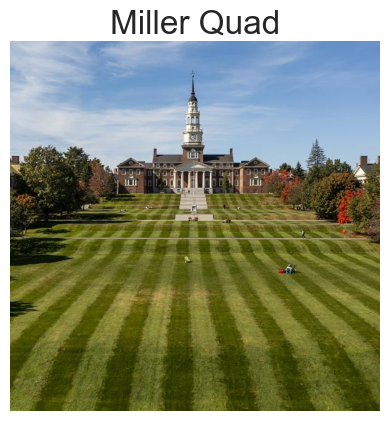

In [30]:
image = Image.open("data/miller_quad.jpg")
image = np.array(image, dtype=np.float32)
image = (image - np.min(image)) / (np.max(image) - np.min(image))
miller_tf = tf.convert_to_tensor(image, dtype=tf.float32)

print('Miller image size:', miller_tf.shape)

show_image(miller_tf, 'Miller Quad')

Allen image size: (600, 600, 3)


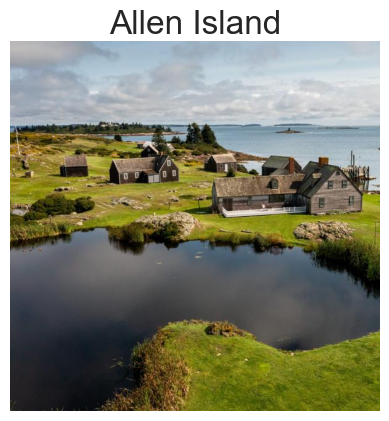

In [31]:
image = Image.open("data/allen_island.jpg")
image = np.array(image, dtype=np.float32)
image = (image - np.min(image)) / (np.max(image) - np.min(image))
allen_tf = tf.convert_to_tensor(image, dtype=tf.float32)

print('Allen image size:', allen_tf.shape)

show_image(allen_tf, 'Allen Island')

### 1b. 1x1 convolution

The 1x1 convolution operation is widely used throughout InceptionNet. While it can be viewed as just a special case as regular convolution (i.e. just plug and chug with `tf.nn.conv2d` and you will get the correct answer), it offers a different interpretation than 2D convolution. We will explore this new perspective using image processing.

Implement the function `conv_1x1` in `inception_ops.py` then fill in the code below to call it on the Miller image. 

In [32]:
from inception_ops import conv_1x1

The following cell should use 1x1 convolution to convert the colored Miller image into grayscale, using a filter that [weights colors in proportion to which the human eye is sensitive to red, green, and blue wavelengths](https://en.wikipedia.org/wiki/Grayscale#Colorimetric_(perceptual_luminance-preserving)_conversion_to_grayscale). 

The shape of miller_filtered is (600, 600, 1) and min/max is 0.0000/0.9977
The shape should be (600, 600, 1) and the min/max should be 0.0000/0.9977


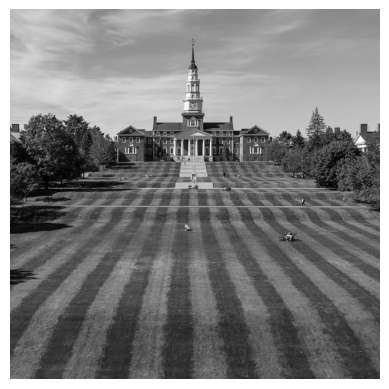

In [33]:
# One filter/neuron with 3 input color chans
gray_filter = tf.constant([[0.299], [0.587], [0.114]])

# TODO: Call conv_1x1 on your preprocessed Miller image
miller_filtered = conv_1x1(miller_tf, gray_filter)

print(f'The shape of miller_filtered is {miller_filtered.shape} and min/max is {tf.reduce_min(miller_filtered):.4f}/{tf.reduce_max(miller_filtered):.4f}')
print('The shape should be (600, 600, 1) and the min/max should be 0.0000/0.9977')
plt.imshow(miller_filtered, cmap='gray')
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.show()

The following cell should use 1x1 convolution to apply a [Sepia filter](https://stackoverflow.com/questions/1061093/how-is-a-sepia-tone-created) to the Miller image.

The shape of miller_filtered is (600, 600, 3) and min/max is 0.0000/1.0000
The shape should be (600, 600, 3) and the min/max should be 0.0000/1.0000


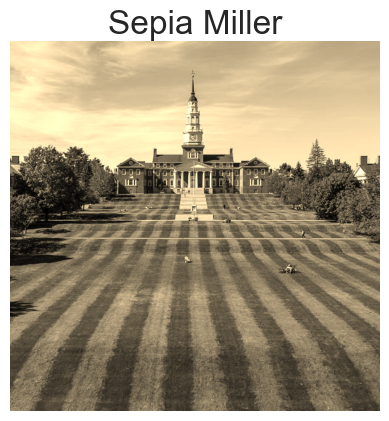

In [34]:
# 3 filters/neurons with 3 input color chans
sepia_filter = tf.constant([[0.393, 0.349, 0.272],
                            [0.769, 0.686, 0.534],
                            [0.189, 0.168, 0.131]])

# TODO: Call conv_1x1 on your preprocessed Miller image
miller_filtered = conv_1x1(miller_tf, sepia_filter)

miller_filtered  = tf.clip_by_value(miller_filtered, clip_value_min=0, clip_value_max=1)

print(f'The shape of miller_filtered is {miller_filtered.shape} and min/max is {tf.reduce_min(miller_filtered):.4f}/{tf.reduce_max(miller_filtered):.4f}')
print('The shape should be (600, 600, 3) and the min/max should be 0.0000/1.0000')
show_image(miller_filtered, 'Sepia Miller')

### 1c. 1x1 convolution (batch version)

A key limitation of `conv_1x1` is that it only processes a single image input at a time. For this to be useful for neural networks it should be capable of processing a batch of images at a time.

Address this by implementing the function `conv_1x1_batch` in `inception_ops.py` that adds mini-batch (*and stride*) support. Afterward, fill in the code below to apply the Sepia filter to both the Miller and Allen Island images.

In [35]:
from inception_ops import conv_1x1_batch

The mean of the mini-batch is 0.5160 and should be 0.5160.
The shape of miller_filtered is (2, 600, 600, 3) and should be (2, 600, 600, 3)


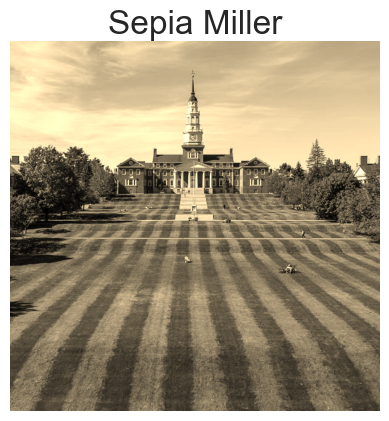

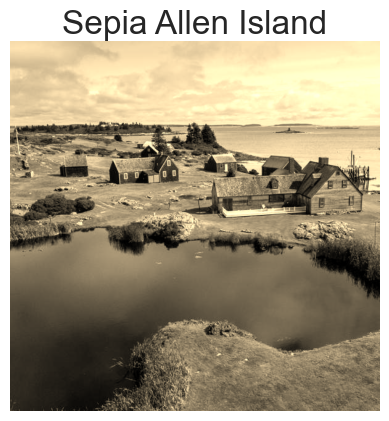

In [36]:
# Combine the two images into a mini-batch
imgs = tf.stack([miller_tf, allen_tf])

# TODO: Call conv_1x1 on both images
imgs_filtered = conv_1x1_batch(imgs, sepia_filter)

print(f'The mean of the mini-batch is {tf.reduce_mean(imgs_filtered):.4f} and should be 0.5160.')

imgs_filtered  = tf.clip_by_value(imgs_filtered, clip_value_min=0, clip_value_max=1)

print(f'The shape of miller_filtered is {imgs_filtered.shape} and should be (2, 600, 600, 3)')
show_image(imgs_filtered[0], 'Sepia Miller')
show_image(imgs_filtered[1], 'Sepia Allen Island')

Below, perform the same test, but use a stride of 8. If everything is working as expected, the output images should look similar to how they do above, but much blockier/pixelated.

The mean of the mini-batch is 0.5192 and should be 0.5192.
The shape of miller_filtered is (2, 75, 75, 3) and should be (2, 75, 75, 3)


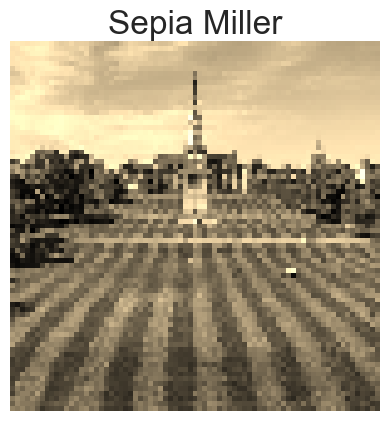

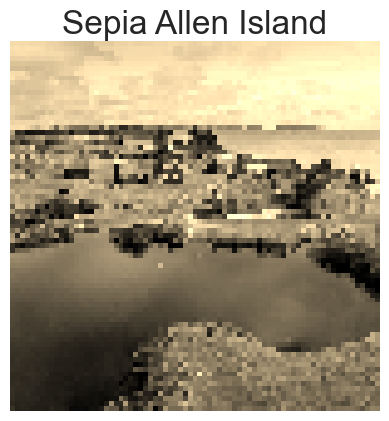

In [37]:
# TODO: Call conv_1x1 on both images
imgs_filtered = conv_1x1_batch(imgs, sepia_filter, strides=8)

print(f'The mean of the mini-batch is {tf.reduce_mean(imgs_filtered):.4f} and should be 0.5192.')

imgs_filtered  = tf.clip_by_value(imgs_filtered, clip_value_min=0, clip_value_max=1)

print(f'The shape of miller_filtered is {imgs_filtered.shape} and should be (2, 75, 75, 3)')
show_image(imgs_filtered[0], 'Sepia Miller')
show_image(imgs_filtered[1], 'Sepia Allen Island')

# Task 2: Build and test the Inception Block

With 1x1 convolution implemented, let's build Inception Net! We will work our way up the neural network hierarchy — start by building new layers and blocks then assembling them into Inception Net.

### 2a. Copy files from Project 1

Copy over your deep learning library from Project 1: `datasets.py`, `tf_util.py`, `layers.py`, `block.py`, `network.py`.

This will allow you to reuse all your training/layer/network code that you developed in Project 1! You only need to create components that are unique and new to Inception Net.

### 2b. Implement `Conv2D1x1` layer

This is the network layer that performs 1x1 convolution. The class inherits from `Conv2D` and is located in `inception_layers.py`.

In [38]:
from inception_layers import Conv2D1x1

#### Test: `Conv2D1x1` layer

(1/3) Testing weights and bias

In [39]:
tf.random.set_seed(0)
conv = Conv2D1x1('Test1x1', 4, do_batch_norm=False)
conv(tf.ones([1, 4, 4, 3]))
print(f'Your weights are\n{conv.get_wts().numpy()}')
print('and they should be:')
print('''[[ 1.2337776  0.3453145 -0.3426796 -0.8459209]
 [-1.0098659  0.3839764 -0.0114104  0.9706988]
 [ 0.4919664  0.4896621 -0.5762113 -0.3535231]]''')
print(f'Your biases are\n{conv.get_b().numpy()}')
print('and they should be:')
print('''[0. 0. 0. 0.]''')

Your weights are
[[ 1.2337776  0.3453145 -0.3426796 -0.8459209]
 [-1.0098659  0.3839764 -0.0114104  0.9706988]
 [ 0.4919664  0.4896621 -0.5762113 -0.3535231]]
and they should be:
[[ 1.2337776  0.3453145 -0.3426796 -0.8459209]
 [-1.0098659  0.3839764 -0.0114104  0.9706988]
 [ 0.4919664  0.4896621 -0.5762113 -0.3535231]]
Your biases are
[0. 0. 0. 0.]
and they should be:
[0. 0. 0. 0.]


(2/3) Testing activation and stride

In [40]:
tf.random.set_seed(0)
conv = Conv2D1x1('Test1x1', 4, strides=2)
tf.random.set_seed(1)
test_net_acts = conv(tf.random.uniform([2, 4, 4, 3]))
print(f'Your net_acts are\n{test_net_acts.numpy()}')
print('and they should be:')
print('''[[[[0.        0.        0.        0.       ]
   [0.        0.        0.        0.       ]]

  [[0.1286802 0.        0.        0.       ]
   [0.1233867 0.        0.        0.       ]]]


 [[[0.        0.        0.        0.       ]
   [0.3837539 0.        0.        0.038144 ]]

  [[0.        0.        0.        0.       ]
   [0.3536301 0.        0.        0.5435652]]]]''')

Your net_acts are
[[[[0.        0.        0.        0.       ]
   [0.        0.        0.        0.       ]]

  [[0.1286802 0.        0.        0.       ]
   [0.1233867 0.        0.        0.       ]]]


 [[[0.        0.        0.        0.       ]
   [0.3837539 0.        0.        0.038144 ]]

  [[0.        0.        0.        0.       ]
   [0.3536301 0.        0.        0.5435652]]]]
and they should be:
[[[[0.        0.        0.        0.       ]
   [0.        0.        0.        0.       ]]

  [[0.1286802 0.        0.        0.       ]
   [0.1233867 0.        0.        0.       ]]]


 [[[0.        0.        0.        0.       ]
   [0.3837539 0.        0.        0.038144 ]]

  [[0.        0.        0.        0.       ]
   [0.3536301 0.        0.        0.5435652]]]]


(3/3) Testing batch norm

In [41]:
tf.random.set_seed(0)
conv = Conv2D1x1('Test1x1', 5, strides=2)
conv(tf.ones([1, 4, 4, 3]))
conv.init_batchnorm_params()

conv.set_mode(True)

tf.random.set_seed(1)
for i in range(3):
    test_net_acts = conv(tf.random.uniform([2, 4, 4, 3]))
print(f'Your net_acts after 3 training steps are\n{test_net_acts.numpy()}')
print('and they should be:')
print('''[[[[1.0821913 0.7829832 0.1566384 0.        0.       ]
   [0.        0.        0.9201921 1.5349929 1.4050572]]

  [[0.        0.3684795 0.        1.1567515 1.2164567]
   [0.2499718 0.        1.9366031 0.        0.       ]]]


 [[[0.        0.200867  0.        0.        0.0255171]
   [0.        0.        0.0641299 0.271286  0.2673296]]

  [[1.0891017 1.5742371 0.        0.1243966 0.272232 ]
   [0.844538  0.4010135 0.        0.        0.       ]]]]''')

conv.set_mode(False)

test_net_acts = conv(tf.random.uniform([2, 4, 4, 3]))
print(f'Your net_acts after transitioning to in predict mode \n{test_net_acts.numpy()}')
print('and they should be:')
print('''[[[[0.0776796 0.        0.4667156 0.        0.       ]
   [0.4479264 0.0159945 0.6306992 0.        0.       ]]

  [[0.0817579 0.        0.7232838 0.        0.       ]
   [0.0959485 0.        0.2694484 0.        0.       ]]]


 [[[0.5344409 0.0541097 0.706812  0.2156344 0.1787143]
   [1.0073555 0.237892  0.        0.        0.       ]]

  [[0.2575162 0.        1.3112392 0.        0.       ]
   [0.9776454 0.043461  0.7792924 0.        0.       ]]]]''')

Your net_acts after 3 training steps are
[[[[1.0821913 0.7829832 0.1566384 0.        0.       ]
   [0.        0.        0.9201921 1.5349929 1.4050572]]

  [[0.        0.3684795 0.        1.1567515 1.2164567]
   [0.2499718 0.        1.9366031 0.        0.       ]]]


 [[[0.        0.200867  0.        0.        0.0255171]
   [0.        0.        0.0641299 0.271286  0.2673296]]

  [[1.0891017 1.5742371 0.        0.1243966 0.272232 ]
   [0.844538  0.4010135 0.        0.        0.       ]]]]
and they should be:
[[[[1.0821913 0.7829832 0.1566384 0.        0.       ]
   [0.        0.        0.9201921 1.5349929 1.4050572]]

  [[0.        0.3684795 0.        1.1567515 1.2164567]
   [0.2499718 0.        1.9366031 0.        0.       ]]]


 [[[0.        0.200867  0.        0.        0.0255171]
   [0.        0.        0.0641299 0.271286  0.2673296]]

  [[1.0891017 1.5742371 0.        0.1243966 0.272232 ]
   [0.844538  0.4010135 0.        0.        0.       ]]]]
Your net_acts after transitioning to 

### 2c. Implement the `InceptionBlock` class 

This is located in `inception_block.py`.

The Inception Block is the fundamental computational unit of Inception Net. Here is a refresher on its 4 branch structure:

**Branch 1:** 1x1 convolution.

**Branch 2:** 1x1 convolution → 3x3 2D convolution

**Branch 3:** 1x1 convolution → 5x5 2D convolution

**Branch 4:** 3x3 max pooling → 1x1 convolution

The activations are concatenated together along the neuron dimension to form the output of the block (*i.e. think of the neurons at the end of each branch being lined up next to each other*).

In [42]:
from layers import Conv2D
from inception_block import InceptionBlock

#### Test: `InceptionBlock`

In [43]:
rng = tf.random.Generator.from_seed(0)
test_imgs = rng.uniform(shape=(1, 8, 8, 3))

tf.random.set_seed(1)
in_block = InceptionBlock('testblock', 2, (3, 4), (6, 5), 7, prev_layer_or_block=None)
test_net_acts = in_block(test_imgs)
print(in_block)
print(f'Shape of netActs are: {test_net_acts.shape}')
print(f'Sum of netActs are: {tf.reduce_sum(tf.abs(test_net_acts)).numpy():.1f}')

testblock:
	Conv2D1x1 layer output(testblock/branch4_1_conv1x1) shape: [1, 8, 8, 7]
	MaxPool2D layer output(testblock/branch4_0_maxpool3x3) shape: [1, 8, 8, 3]
	Conv2D layer output(testblock/branch3_1_conv5x5) shape: [1, 8, 8, 5]
	Conv2D1x1 layer output(testblock/branch3_0_conv1x1) shape: [1, 8, 8, 6]
	Conv2D layer output(testblock/branch2_1_conv3x3) shape: [1, 8, 8, 4]
	Conv2D1x1 layer output(testblock/branch2_0_conv1x1) shape: [1, 8, 8, 3]
	Conv2D1x1 layer output(testblock/branch1_0_conv1x1) shape: [1, 8, 8, 2]
Shape of netActs are: (1, 8, 8, 18)
Sum of netActs are: 358.5


The above cell should print:

```
testblock:
	Conv2D1x1 layer output(testblock/branch4_1_conv1x1) shape: [1, 8, 8, 7]
	MaxPool2D layer output(testblock/branch4_0_maxpool3x3) shape: [1, 8, 8, 3]
	Conv2D layer output(testblock/branch3_1_conv5x5) shape: [1, 8, 8, 5]
	Conv2D1x1 layer output(testblock/branch3_0_conv1x1) shape: [1, 8, 8, 6]
	Conv2D layer output(testblock/branch2_1_conv3x3) shape: [1, 8, 8, 4]
	Conv2D1x1 layer output(testblock/branch2_0_conv1x1) shape: [1, 8, 8, 3]
	Conv2D1x1 layer output(testblock/branch1_0_conv1x1) shape: [1, 8, 8, 2]
Shape of netActs are: (1, 8, 8, 18)
Sum of netActs are: 358.5
```

In [44]:
rng = tf.random.Generator.from_seed(0)
test_imgs = rng.uniform(shape=(5, 16, 16, 3))

tf.random.set_seed(1)
conv_blah = Conv2D('convblaaa', 12, (3, 3), wt_init='he')
in_block = InceptionBlock('testblock', 5, (6, 7), (8, 9), 2,
                          prev_layer_or_block=conv_blah)
test_net_acts = in_block(conv_blah(test_imgs))
print(f'Shape of netActs are: {test_net_acts.shape} and should be (5, 16, 16, 23).')
print(f'Sum of abs netActs is: {tf.reduce_sum(tf.abs(test_net_acts)).numpy():.1f} and should be 6726.1.')

Shape of netActs are: (5, 16, 16, 23) and should be (5, 16, 16, 23).
Sum of abs netActs is: 6726.1 and should be 6726.1.


## Task 3: 2D Global Average Pooling

With the exception of the output layer, Inception does away with the large dense hidden layers. In its place, it uses 2D averaging pooling, a new type of net input operation.

### 3a. 2D Global Average Pooling

Implement `global_avg_pooling_2d` in `inception_ops.py` then test it using the **luminance staircase patterns** below.

In [45]:
from inception_ops import global_avg_pooling_2d

Run the following cell to create and visualize some other test luminance staircase inputs.

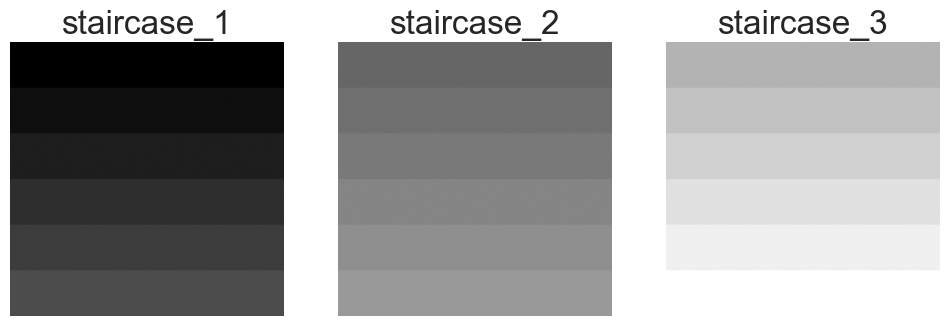

In [46]:
dark_staircase = np.expand_dims(np.repeat(np.linspace(0, 0.3, 6), 100), axis=1)
dark_staircase = np.tile(dark_staircase, reps=(1, 600))
mid_staircase = np.expand_dims(np.repeat(np.linspace(0.4, 0.6, 6), 100), axis=1)
mid_staircase = np.tile(mid_staircase, reps=(1, 600))
light_staircase = np.expand_dims(np.repeat(np.linspace(0.7, 1.0, 6), 100), axis=1)
light_staircase = np.tile(light_staircase, reps=(1, 600))
staircases_tf = tf.expand_dims(tf.stack([dark_staircase, mid_staircase, light_staircase]), axis=-1)

fig, axes = plt.subplots(ncols=3, figsize=(12, 4))

axes[0].imshow(dark_staircase, vmin=0, vmax=1, cmap='gray')
axes[1].imshow(mid_staircase, vmin=0, vmax=1, cmap='gray')
axes[2].imshow(light_staircase, vmin=0, vmax=1, cmap='gray')
axes[0].set_title('staircase_1')
axes[1].set_title('staircase_2')
axes[2].set_title('staircase_3')

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)

In [47]:
#TODO: Call global_avg_pooling_2d on the luminance staircases shown above
avg_pool_result = global_avg_pooling_2d(staircases_tf)

print(avg_pool_result.numpy())

[[0.15]
 [0.5 ]
 [0.85]]


### 3b. Questions

**Question 1:** Interpret what the 3 outputs means in the context of the input images.

**Answer 1:** 
The three outputs represent the average brightness of each staircase image. The first output is for the dark staircase (0.15), the second is for the mid-brightness staircase (0.5), and the third is for the light staircase (0.85).

### 3c. Implement `GlobalAveragePooling2D` layer

This is the network layer that performs 2D average pooling.

In [48]:
from inception_layers import GlobalAveragePooling2D

#### Test: `GlobalAveragePooling2D` layer

In [49]:
tf.random.set_seed(0)
avgLayer = GlobalAveragePooling2D('TestAvg')
net_acts = avgLayer(tf.random.uniform([5, 4, 4, 3]))
print(f'Your net_acts are\n{net_acts}')
print('and they should be:')
print('''[[0.3502938 0.4452531 0.6562439]
 [0.5894256 0.5440583 0.3731586]
 [0.462571  0.4454759 0.5653416]
 [0.4206027 0.5466459 0.4712621]
 [0.4241399 0.5988445 0.4847081]]''')

Your net_acts are
[[0.3502938 0.4452531 0.6562439]
 [0.5894256 0.5440583 0.3731586]
 [0.462571  0.4454759 0.5653416]
 [0.4206027 0.5466459 0.4712621]
 [0.4241399 0.5988445 0.4847081]]
and they should be:
[[0.3502938 0.4452531 0.6562439]
 [0.5894256 0.5440583 0.3731586]
 [0.462571  0.4454759 0.5653416]
 [0.4206027 0.5466459 0.4712621]
 [0.4241399 0.5988445 0.4847081]]


## Task 4: Build Inception Net and train it on CIFAR-10

All the building blocks for Inception Net are complete, so let's assemble the network! Here is an overview summary of the architecture:

Conv2D → MaxPool2D → InceptionBlock → InceptionBlock → MaxPool2D → InceptionBlock → InceptionBlock → InceptionBlock → MaxPool2D → GlobalAveragePool2D → Dropout → Dense

At the end of the task, you will train your Inception Net on CIFAR-10.

### 4a. Assemble Inception net

The `InceptionNet` class is located in `inception_net.py`.

In [2]:
from inception_net import InceptionNet

#### Test: `InceptionNet` architecture

In the cell below, create a test Inception Net appropriate for CIFAR-10 then compile to see the network summary.

In [3]:
model = InceptionNet(10, (32,32,3))
model.compile()

2025-04-06 15:49:41.684907: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20601 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


2025-04-06 15:49:48.529180: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 90400


---------------------------------------------------------------------------
Dense layer output(Output) shape: [1, 10]
Dropout layer output(Dropout) shape: [1, 580]
Global Avg Pooling 2D layer output(GlobalPool) shape: [1, 580]
MaxPool2D layer output(MaxPool3x3_2) shape: [1, 4, 4, 580]
Inception5:
	Conv2D1x1 layer output(Inception5/branch4_1_conv1x1) shape: [1, 8, 8, 128]
	MaxPool2D layer output(Inception5/branch4_0_maxpool3x3) shape: [1, 8, 8, 320]
	Conv2D layer output(Inception5/branch3_1_conv5x5) shape: [1, 8, 8, 128]
	Conv2D1x1 layer output(Inception5/branch3_0_conv1x1) shape: [1, 8, 8, 64]
	Conv2D layer output(Inception5/branch2_1_conv3x3) shape: [1, 8, 8, 196]
	Conv2D1x1 layer output(Inception5/branch2_0_conv1x1) shape: [1, 8, 8, 128]
	Conv2D1x1 layer output(Inception5/branch1_0_conv1x1) shape: [1, 8, 8, 128]
Inception4:
	Conv2D1x1 layer output(Inception4/branch4_1_conv1x1) shape: [1, 8, 8, 64]
	MaxPool2D layer output(Inception4/branch4_0_maxpool3x3) shape: [1, 8, 8, 320]
	Conv2D 

The above cell should print:

```
---------------------------------------------------------------------------
Dense layer output(Output) shape: [1, 10]
Dropout layer output(Dropout) shape: [1, 580]
Global Avg Pooling 2D layer output(GlobalPool) shape: [1, 580]
MaxPool2D layer output(MaxPool3x3_2) shape: [1, 4, 4, 580]
Inception5:
	Conv2D1x1 layer output(Inception5/branch4_1_conv1x1) shape: [1, 8, 8, 128]
	MaxPool2D layer output(Inception5/branch4_0_maxpool3x3) shape: [1, 8, 8, 320]
	Conv2D layer output(Inception5/branch3_1_conv5x5) shape: [1, 8, 8, 128]
	Conv2D1x1 layer output(Inception5/branch3_0_conv1x1) shape: [1, 8, 8, 64]
	Conv2D layer output(Inception5/branch2_1_conv3x3) shape: [1, 8, 8, 196]
	Conv2D1x1 layer output(Inception5/branch2_0_conv1x1) shape: [1, 8, 8, 128]
	Conv2D1x1 layer output(Inception5/branch1_0_conv1x1) shape: [1, 8, 8, 128]
Inception4:
	Conv2D1x1 layer output(Inception4/branch4_1_conv1x1) shape: [1, 8, 8, 64]
	MaxPool2D layer output(Inception4/branch4_0_maxpool3x3) shape: [1, 8, 8, 320]
	Conv2D layer output(Inception4/branch3_1_conv5x5) shape: [1, 8, 8, 64]
	Conv2D1x1 layer output(Inception4/branch3_0_conv1x1) shape: [1, 8, 8, 32]
	Conv2D layer output(Inception4/branch2_1_conv3x3) shape: [1, 8, 8, 128]
	Conv2D1x1 layer output(Inception4/branch2_0_conv1x1) shape: [1, 8, 8, 96]
	Conv2D1x1 layer output(Inception4/branch1_0_conv1x1) shape: [1, 8, 8, 64]
Inception3:
	Conv2D1x1 layer output(Inception3/branch4_1_conv1x1) shape: [1, 8, 8, 64]
	MaxPool2D layer output(Inception3/branch4_0_maxpool3x3) shape: [1, 8, 8, 320]
	Conv2D layer output(Inception3/branch3_1_conv5x5) shape: [1, 8, 8, 64]
	Conv2D1x1 layer output(Inception3/branch3_0_conv1x1) shape: [1, 8, 8, 32]
	Conv2D layer output(Inception3/branch2_1_conv3x3) shape: [1, 8, 8, 128]
	Conv2D1x1 layer output(Inception3/branch2_0_conv1x1) shape: [1, 8, 8, 96]
	Conv2D1x1 layer output(Inception3/branch1_0_conv1x1) shape: [1, 8, 8, 64]
MaxPool2D layer output(MaxPool3x3_1) shape: [1, 8, 8, 320]
Inception2:
	Conv2D1x1 layer output(Inception2/branch4_1_conv1x1) shape: [1, 16, 16, 64]
	MaxPool2D layer output(Inception2/branch4_0_maxpool3x3) shape: [1, 16, 16, 160]
	Conv2D layer output(Inception2/branch3_1_conv5x5) shape: [1, 16, 16, 64]
	Conv2D1x1 layer output(Inception2/branch3_0_conv1x1) shape: [1, 16, 16, 32]
	Conv2D layer output(Inception2/branch2_1_conv3x3) shape: [1, 16, 16, 128]
	Conv2D1x1 layer output(Inception2/branch2_0_conv1x1) shape: [1, 16, 16, 64]
	Conv2D1x1 layer output(Inception2/branch1_0_conv1x1) shape: [1, 16, 16, 64]
Inception1:
	Conv2D1x1 layer output(Inception1/branch4_1_conv1x1) shape: [1, 16, 16, 32]
	MaxPool2D layer output(Inception1/branch4_0_maxpool3x3) shape: [1, 16, 16, 64]
	Conv2D layer output(Inception1/branch3_1_conv5x5) shape: [1, 16, 16, 32]
	Conv2D1x1 layer output(Inception1/branch3_0_conv1x1) shape: [1, 16, 16, 16]
	Conv2D layer output(Inception1/branch2_1_conv3x3) shape: [1, 16, 16, 64]
	Conv2D1x1 layer output(Inception1/branch2_0_conv1x1) shape: [1, 16, 16, 32]
	Conv2D1x1 layer output(Inception1/branch1_0_conv1x1) shape: [1, 16, 16, 32]
MaxPool2D layer output(MaxPool3x3_0) shape: [1, 16, 16, 64]
Conv2D layer output(Conv2D_1) shape: [1, 32, 32, 64]
---------------------------------------------------------------------------
```

### 4b. Test Inception Net by overfitting small CIFAR-10 dev set

To help test whether your Inception Net is working, train your network is overfit a small amount of data.

Below:
1. Create a dev set from the 1st 500 training CIFAR-10 samples.
2. Train your net on the dev set for 40 epochs (turn off early stopping for this test). *Do not use any regularization.* 

Your training loss should start out at ~2.5 after the first epoch and rapidly plummet to 0.01 or less by about 25 epochs.

**Note:** If you coded `fit` to assume there will always be a validation set present, no problem, just plug in the dev set for both the train and val sets here.

In [4]:
from datasets import get_dataset

In [6]:
x_train, y_train, x_val, y_val, x_test, y_test, classnames = get_dataset('cifar10')
x_dev = x_train[:500]
y_dev = y_train[:500]

In [7]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

model = InceptionNet(10, (32,32,3), reg = 0)
model.compile()
model.fit(x_dev, y_dev, x_dev, y_dev, max_epochs = 40, patience = 40, val_every = 1, verbose = True)

---------------------------------------------------------------------------
Dense layer output(Output) shape: [1, 10]
Dropout layer output(Dropout) shape: [1, 580]
Global Avg Pooling 2D layer output(GlobalPool) shape: [1, 580]
MaxPool2D layer output(MaxPool3x3_2) shape: [1, 4, 4, 580]
Inception5:
	Conv2D1x1 layer output(Inception5/branch4_1_conv1x1) shape: [1, 8, 8, 128]
	MaxPool2D layer output(Inception5/branch4_0_maxpool3x3) shape: [1, 8, 8, 320]
	Conv2D layer output(Inception5/branch3_1_conv5x5) shape: [1, 8, 8, 128]
	Conv2D1x1 layer output(Inception5/branch3_0_conv1x1) shape: [1, 8, 8, 64]
	Conv2D layer output(Inception5/branch2_1_conv3x3) shape: [1, 8, 8, 196]
	Conv2D1x1 layer output(Inception5/branch2_0_conv1x1) shape: [1, 8, 8, 128]
	Conv2D1x1 layer output(Inception5/branch1_0_conv1x1) shape: [1, 8, 8, 128]
Inception4:
	Conv2D1x1 layer output(Inception4/branch4_1_conv1x1) shape: [1, 8, 8, 64]
	MaxPool2D layer output(Inception4/branch4_0_maxpool3x3) shape: [1, 8, 8, 320]
	Conv2D 

I0000 00:00:1743954652.358460     585 service.cc:145] XLA service 0x7c718369d930 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743954652.358498     585 service.cc:153]   StreamExecutor device (0): NVIDIA L4, Compute Capability 8.9


2025-04-06 15:50:52.811631: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


I0000 00:00:1743954653.780129     585 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch 1: Training Loss = 4.8802, Validation Loss = 2.4033, Validation Accuracy = 0.1228
Epoch 1/40 took 24.4066 seconds


Epoch 2: Training Loss = 2.4234, Validation Loss = 2.2431, Validation Accuracy = 0.1295
Epoch 2/40 took 0.2112 seconds
Epoch 3: Training Loss = 2.2408, Validation Loss = 2.1851, Validation Accuracy = 0.1808
Epoch 3/40 took 0.1233 seconds


Epoch 4: Training Loss = 2.1623, Validation Loss = 2.1351, Validation Accuracy = 0.1897
Epoch 4/40 took 0.1222 seconds
Epoch 5: Training Loss = 2.1406, Validation Loss = 2.0916, Validation Accuracy = 0.2455
Epoch 5/40 took 0.1398 seconds


Epoch 6: Training Loss = 2.0475, Validation Loss = 2.0389, Validation Accuracy = 0.2589
Epoch 6/40 took 0.1203 seconds
Epoch 7: Training Loss = 2.0345, Validation Loss = 1.9488, Validation Accuracy = 0.3125
Epoch 7/40 took 0.1192 seconds


Epoch 8: Training Loss = 2.0451, Validation Loss = 1.9318, Validation Accuracy = 0.3259
Epoch 8/40 took 0.1201 seconds
Epoch 9: Training Loss = 1.9363, Validation Loss = 1.8961, Validation Accuracy = 0.2500
Epoch 9/40 took 0.1211 seconds


Epoch 10: Training Loss = 1.8386, Validation Loss = 1.7733, Validation Accuracy = 0.3415
Epoch 10/40 took 0.1374 seconds
Epoch 11: Training Loss = 1.7895, Validation Loss = 1.7323, Validation Accuracy = 0.3951
Epoch 11/40 took 0.1212 seconds


Epoch 12: Training Loss = 1.8047, Validation Loss = 1.6632, Validation Accuracy = 0.3996
Epoch 12/40 took 0.1198 seconds
Epoch 13: Training Loss = 1.8229, Validation Loss = 1.7289, Validation Accuracy = 0.3839
Epoch 13/40 took 0.1194 seconds


Epoch 14: Training Loss = 1.7055, Validation Loss = 1.6106, Validation Accuracy = 0.3929
Epoch 14/40 took 0.1194 seconds
Epoch 15: Training Loss = 1.5999, Validation Loss = 1.5277, Validation Accuracy = 0.3906
Epoch 15/40 took 0.1206 seconds


Epoch 16: Training Loss = 1.5693, Validation Loss = 1.5011, Validation Accuracy = 0.4598
Epoch 16/40 took 0.1204 seconds
Epoch 17: Training Loss = 1.6345, Validation Loss = 1.4568, Validation Accuracy = 0.4688
Epoch 17/40 took 0.1199 seconds


Epoch 18: Training Loss = 1.5131, Validation Loss = 1.4563, Validation Accuracy = 0.4888
Epoch 18/40 took 0.1203 seconds
Epoch 19: Training Loss = 1.5285, Validation Loss = 1.5241, Validation Accuracy = 0.4509
Epoch 19/40 took 0.1233 seconds


Epoch 20: Training Loss = 1.4660, Validation Loss = 1.3997, Validation Accuracy = 0.4665
Epoch 20/40 took 0.1224 seconds
Epoch 21: Training Loss = 1.3001, Validation Loss = 1.2284, Validation Accuracy = 0.5915
Epoch 21/40 took 0.1219 seconds


Epoch 22: Training Loss = 1.2392, Validation Loss = 1.1457, Validation Accuracy = 0.5871
Epoch 22/40 took 0.1213 seconds
Epoch 23: Training Loss = 1.2185, Validation Loss = 1.1577, Validation Accuracy = 0.5893
Epoch 23/40 took 0.1218 seconds


Epoch 24: Training Loss = 1.0979, Validation Loss = 0.9803, Validation Accuracy = 0.6585
Epoch 24/40 took 0.1228 seconds
Epoch 25: Training Loss = 0.9837, Validation Loss = 0.8512, Validation Accuracy = 0.7344
Epoch 25/40 took 0.1220 seconds


Epoch 26: Training Loss = 0.8569, Validation Loss = 0.8438, Validation Accuracy = 0.6964
Epoch 26/40 took 0.1224 seconds
Epoch 27: Training Loss = 0.8395, Validation Loss = 0.8037, Validation Accuracy = 0.7031
Epoch 27/40 took 0.1221 seconds


Epoch 28: Training Loss = 0.8573, Validation Loss = 0.6617, Validation Accuracy = 0.7656
Epoch 28/40 took 0.1208 seconds
Epoch 29: Training Loss = 0.7720, Validation Loss = 0.7205, Validation Accuracy = 0.7366
Epoch 29/40 took 0.1207 seconds


Epoch 30: Training Loss = 0.9090, Validation Loss = 1.0021, Validation Accuracy = 0.6429
Epoch 30/40 took 0.1210 seconds
Epoch 31: Training Loss = 0.8505, Validation Loss = 0.6742, Validation Accuracy = 0.7768
Epoch 31/40 took 0.1230 seconds


Epoch 32: Training Loss = 0.6741, Validation Loss = 0.6667, Validation Accuracy = 0.7835
Epoch 32/40 took 0.1238 seconds
Epoch 33: Training Loss = 0.6691, Validation Loss = 0.5425, Validation Accuracy = 0.8527
Epoch 33/40 took 0.1222 seconds


Epoch 34: Training Loss = 0.5501, Validation Loss = 0.4570, Validation Accuracy = 0.8460
Epoch 34/40 took 0.1223 seconds
Epoch 35: Training Loss = 0.5757, Validation Loss = 0.6244, Validation Accuracy = 0.7567
Epoch 35/40 took 0.1219 seconds


Epoch 36: Training Loss = 0.6262, Validation Loss = 0.4382, Validation Accuracy = 0.8683
Epoch 36/40 took 0.1220 seconds
Epoch 37: Training Loss = 0.4667, Validation Loss = 0.3533, Validation Accuracy = 0.9040
Epoch 37/40 took 0.1201 seconds


Epoch 38: Training Loss = 0.4030, Validation Loss = 0.3867, Validation Accuracy = 0.8884
Epoch 38/40 took 0.1200 seconds
Epoch 39: Training Loss = 0.4421, Validation Loss = 0.3008, Validation Accuracy = 0.9129
Epoch 39/40 took 0.1211 seconds


Epoch 40: Training Loss = 0.4067, Validation Loss = 0.2095, Validation Accuracy = 0.9576
Epoch 40/40 took 0.1224 seconds
Finished training after 40 epochs!


([4.880209,
  2.4234066,
  2.2407997,
  2.1622763,
  2.1405778,
  2.0475268,
  2.0344837,
  2.0450766,
  1.9363315,
  1.8386168,
  1.7894709,
  1.8046894,
  1.8228927,
  1.7054691,
  1.5999182,
  1.5692518,
  1.6344788,
  1.5130963,
  1.5284811,
  1.4660044,
  1.3000845,
  1.2391797,
  1.2184905,
  1.0979388,
  0.98372734,
  0.85685956,
  0.83947515,
  0.8573173,
  0.7720061,
  0.909001,
  0.85052896,
  0.6740732,
  0.66911244,
  0.55013394,
  0.57569647,
  0.6261521,
  0.46672118,
  0.402951,
  0.44206047,
  0.40667543],
 [2.4033055,
  2.2430503,
  2.1851194,
  2.135065,
  2.091617,
  2.038852,
  1.9488004,
  1.9317526,
  1.8960742,
  1.7733241,
  1.7322903,
  1.663184,
  1.7289364,
  1.6105648,
  1.5276934,
  1.5010809,
  1.4567615,
  1.4563447,
  1.5241259,
  1.3997318,
  1.2283946,
  1.1456503,
  1.1577051,
  0.98027486,
  0.85122424,
  0.84377354,
  0.8037241,
  0.66165936,
  0.720473,
  1.002102,
  0.6742347,
  0.66674155,
  0.5425409,
  0.4570484,
  0.6244067,
  0.43820307,
  0.

### 4c. Train Inception Net on CIFAR-10

Now it is time for a real deal training run! Use default hyperparameters, except:
- regularization of `1.5`
- early stopping patience of `15`, learning rate patience of `4`. *Tweak these up/down slightly ast needed.*

Compute and print the accuracy on the test set. Your val/test accuracy should be in the 80s.

**Note:**
- This training session should take a few hours. 1-3 minutes per epoch is reasonable. If it is much longer than that, there likely is an issue.
- Within a few epochs (*perhaps no more than 5*), you should see the training loss decrease sharply and validation accuracy increase sharply.

In [8]:
x_train, y_train, x_val, y_val, x_test, y_test, classnames = get_dataset('cifar10')
print(x_train.shape)

(45000, 32, 32, 3)


In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

model = InceptionNet(10, (32,32,3), reg = 1.5)
model.compile(optimizer='adamw')
model.fit(x_train, y_train, x_val, y_val, max_epochs = 10000, patience = 15, val_every = 1, verbose = True, lr_patience = 4)

---------------------------------------------------------------------------
Dense layer output(Output) shape: [1, 10]
Dropout layer output(Dropout) shape: [1, 580]
Global Avg Pooling 2D layer output(GlobalPool) shape: [1, 580]
MaxPool2D layer output(MaxPool3x3_2) shape: [1, 4, 4, 580]
Inception5:
	Conv2D1x1 layer output(Inception5/branch4_1_conv1x1) shape: [1, 8, 8, 128]
	MaxPool2D layer output(Inception5/branch4_0_maxpool3x3) shape: [1, 8, 8, 320]
	Conv2D layer output(Inception5/branch3_1_conv5x5) shape: [1, 8, 8, 128]
	Conv2D1x1 layer output(Inception5/branch3_0_conv1x1) shape: [1, 8, 8, 64]
	Conv2D layer output(Inception5/branch2_1_conv3x3) shape: [1, 8, 8, 196]
	Conv2D1x1 layer output(Inception5/branch2_0_conv1x1) shape: [1, 8, 8, 128]
	Conv2D1x1 layer output(Inception5/branch1_0_conv1x1) shape: [1, 8, 8, 128]
Inception4:
	Conv2D1x1 layer output(Inception4/branch4_1_conv1x1) shape: [1, 8, 8, 64]
	MaxPool2D layer output(Inception4/branch4_0_maxpool3x3) shape: [1, 8, 8, 320]
	Conv2D 

Epoch 1: Training Loss = 1.7168, Validation Loss = 1.4232, Validation Accuracy = 0.4764
Epoch 1/10000 took 21.0931 seconds


Epoch 2: Training Loss = 1.2819, Validation Loss = 1.1788, Validation Accuracy = 0.5629
Epoch 2/10000 took 8.3406 seconds


Epoch 3: Training Loss = 1.1796, Validation Loss = 1.0487, Validation Accuracy = 0.6212
Epoch 3/10000 took 8.3591 seconds


Epoch 4: Training Loss = 1.0994, Validation Loss = 1.1432, Validation Accuracy = 0.5893
Epoch 4/10000 took 8.3642 seconds


Epoch 5: Training Loss = 1.0797, Validation Loss = 0.9921, Validation Accuracy = 0.6378
Epoch 5/10000 took 8.4012 seconds


Epoch 6: Training Loss = 1.0454, Validation Loss = 1.1037, Validation Accuracy = 0.5958
Epoch 6/10000 took 8.4274 seconds


Epoch 7: Training Loss = 1.0273, Validation Loss = 0.9791, Validation Accuracy = 0.6448
Epoch 7/10000 took 8.4236 seconds


Epoch 8: Training Loss = 0.9883, Validation Loss = 0.8853, Validation Accuracy = 0.6907
Epoch 8/10000 took 8.4593 seconds


Epoch 9: Training Loss = 0.9745, Validation Loss = 0.9551, Validation Accuracy = 0.6615
Epoch 9/10000 took 8.4218 seconds


Epoch 10: Training Loss = 0.9706, Validation Loss = 0.9214, Validation Accuracy = 0.6751
Epoch 10/10000 took 8.4157 seconds


Epoch 11: Training Loss = 0.9329, Validation Loss = 0.8601, Validation Accuracy = 0.6933
Epoch 11/10000 took 8.3711 seconds


Epoch 12: Training Loss = 0.9255, Validation Loss = 0.8491, Validation Accuracy = 0.7017
Epoch 12/10000 took 8.3753 seconds


Epoch 13: Training Loss = 0.9134, Validation Loss = 0.8914, Validation Accuracy = 0.6943
Epoch 13/10000 took 8.3918 seconds


Epoch 14: Training Loss = 0.9135, Validation Loss = 0.9310, Validation Accuracy = 0.6795
Epoch 14/10000 took 8.3854 seconds


Current lr= 0.001 Updated lr= 0.0005
Epoch 15: Training Loss = 0.8972, Validation Loss = 0.9056, Validation Accuracy = 0.6805
Epoch 15/10000 took 8.3880 seconds


Epoch 16: Training Loss = 0.7770, Validation Loss = 0.7939, Validation Accuracy = 0.7218
Epoch 16/10000 took 8.3961 seconds


Epoch 17: Training Loss = 0.7862, Validation Loss = 0.8640, Validation Accuracy = 0.6931
Epoch 17/10000 took 8.3868 seconds


Epoch 18: Training Loss = 0.7804, Validation Loss = 0.7516, Validation Accuracy = 0.7404
Epoch 18/10000 took 8.4001 seconds


Epoch 19: Training Loss = 0.7605, Validation Loss = 0.7876, Validation Accuracy = 0.7270
Epoch 19/10000 took 8.4005 seconds


Epoch 20: Training Loss = 0.7740, Validation Loss = 0.7136, Validation Accuracy = 0.7544
Epoch 20/10000 took 8.3932 seconds


Epoch 21: Training Loss = 0.7520, Validation Loss = 0.7848, Validation Accuracy = 0.7284
Epoch 21/10000 took 8.3978 seconds


Epoch 22: Training Loss = 0.7535, Validation Loss = 0.7323, Validation Accuracy = 0.7502
Epoch 22/10000 took 8.4244 seconds


Current lr= 0.0005 Updated lr= 0.00025
Epoch 23: Training Loss = 0.7540, Validation Loss = 0.7864, Validation Accuracy = 0.7258
Epoch 23/10000 took 8.3967 seconds


Epoch 24: Training Loss = 0.6715, Validation Loss = 0.6609, Validation Accuracy = 0.7817
Epoch 24/10000 took 8.4334 seconds


Epoch 25: Training Loss = 0.6651, Validation Loss = 0.7078, Validation Accuracy = 0.7522
Epoch 25/10000 took 8.4140 seconds


Epoch 26: Training Loss = 0.6623, Validation Loss = 0.6963, Validation Accuracy = 0.7628
Epoch 26/10000 took 8.3957 seconds


Epoch 27: Training Loss = 0.6697, Validation Loss = 0.7516, Validation Accuracy = 0.7402
Epoch 27/10000 took 8.4027 seconds


Epoch 28: Training Loss = 0.6641, Validation Loss = 0.6808, Validation Accuracy = 0.7682
Epoch 28/10000 took 8.3944 seconds


Epoch 29: Training Loss = 0.6597, Validation Loss = 0.6838, Validation Accuracy = 0.7628
Epoch 29/10000 took 8.4074 seconds


Epoch 30: Training Loss = 0.6352, Validation Loss = 0.6490, Validation Accuracy = 0.7742
Epoch 30/10000 took 8.4001 seconds


Epoch 31: Training Loss = 0.6561, Validation Loss = 0.6364, Validation Accuracy = 0.7823
Epoch 31/10000 took 8.3945 seconds


Epoch 32: Training Loss = 0.6515, Validation Loss = 0.6604, Validation Accuracy = 0.7712
Epoch 32/10000 took 8.3853 seconds


Epoch 33: Training Loss = 0.6487, Validation Loss = 0.6441, Validation Accuracy = 0.7845
Epoch 33/10000 took 8.4023 seconds


Epoch 34: Training Loss = 0.6516, Validation Loss = 0.6156, Validation Accuracy = 0.7961
Epoch 34/10000 took 8.4274 seconds


Epoch 35: Training Loss = 0.6335, Validation Loss = 0.6881, Validation Accuracy = 0.7698
Epoch 35/10000 took 8.4159 seconds


Epoch 36: Training Loss = 0.6461, Validation Loss = 0.6875, Validation Accuracy = 0.7650
Epoch 36/10000 took 8.4011 seconds


Current lr= 0.00025 Updated lr= 0.000125
Epoch 37: Training Loss = 0.6454, Validation Loss = 0.6252, Validation Accuracy = 0.7847
Epoch 37/10000 took 8.4038 seconds


Epoch 38: Training Loss = 0.5835, Validation Loss = 0.6253, Validation Accuracy = 0.7879
Epoch 38/10000 took 8.3914 seconds


Epoch 39: Training Loss = 0.5820, Validation Loss = 0.6210, Validation Accuracy = 0.7885
Epoch 39/10000 took 8.4286 seconds


Epoch 40: Training Loss = 0.5802, Validation Loss = 0.6170, Validation Accuracy = 0.7881
Epoch 40/10000 took 8.4392 seconds


Epoch 41: Training Loss = 0.5710, Validation Loss = 0.6494, Validation Accuracy = 0.7730
Epoch 41/10000 took 8.4045 seconds


Epoch 42: Training Loss = 0.5680, Validation Loss = 0.6130, Validation Accuracy = 0.7909
Epoch 42/10000 took 8.4039 seconds


Epoch 43: Training Loss = 0.5676, Validation Loss = 0.6582, Validation Accuracy = 0.7746
Epoch 43/10000 took 8.4018 seconds


Epoch 44: Training Loss = 0.5594, Validation Loss = 0.5971, Validation Accuracy = 0.7977
Epoch 44/10000 took 8.4185 seconds


Epoch 45: Training Loss = 0.5655, Validation Loss = 0.6325, Validation Accuracy = 0.7815
Epoch 45/10000 took 8.4249 seconds


Epoch 46: Training Loss = 0.5538, Validation Loss = 0.6312, Validation Accuracy = 0.7881
Epoch 46/10000 took 8.4298 seconds


Epoch 47: Training Loss = 0.5646, Validation Loss = 0.5898, Validation Accuracy = 0.7999
Epoch 47/10000 took 8.4186 seconds


Epoch 48: Training Loss = 0.5594, Validation Loss = 0.5969, Validation Accuracy = 0.7995
Epoch 48/10000 took 8.4092 seconds


Epoch 49: Training Loss = 0.5474, Validation Loss = 0.6044, Validation Accuracy = 0.7973
Epoch 49/10000 took 8.4146 seconds


Current lr= 0.000125 Updated lr= 6.25e-05
Epoch 50: Training Loss = 0.5568, Validation Loss = 0.6523, Validation Accuracy = 0.7780
Epoch 50/10000 took 8.4303 seconds


Epoch 51: Training Loss = 0.5154, Validation Loss = 0.5690, Validation Accuracy = 0.8019
Epoch 51/10000 took 8.4199 seconds


Epoch 52: Training Loss = 0.5128, Validation Loss = 0.5676, Validation Accuracy = 0.8089
Epoch 52/10000 took 8.4042 seconds


Epoch 53: Training Loss = 0.5046, Validation Loss = 0.5682, Validation Accuracy = 0.8071
Epoch 53/10000 took 8.4042 seconds


Epoch 54: Training Loss = 0.5048, Validation Loss = 0.5761, Validation Accuracy = 0.8057
Epoch 54/10000 took 8.3887 seconds


Current lr= 6.25e-05 Updated lr= 3.125e-05
Epoch 55: Training Loss = 0.4977, Validation Loss = 0.5875, Validation Accuracy = 0.7935
Epoch 55/10000 took 8.4123 seconds


Epoch 56: Training Loss = 0.4727, Validation Loss = 0.5424, Validation Accuracy = 0.8165
Epoch 56/10000 took 8.4555 seconds


Epoch 57: Training Loss = 0.4774, Validation Loss = 0.5446, Validation Accuracy = 0.8141
Epoch 57/10000 took 8.4232 seconds


Epoch 58: Training Loss = 0.4756, Validation Loss = 0.5547, Validation Accuracy = 0.8081
Epoch 58/10000 took 8.4136 seconds


Epoch 59: Training Loss = 0.4697, Validation Loss = 0.5515, Validation Accuracy = 0.8103
Epoch 59/10000 took 8.4439 seconds


Current lr= 3.125e-05 Updated lr= 1.5625e-05
Epoch 60: Training Loss = 0.4651, Validation Loss = 0.5477, Validation Accuracy = 0.8147
Epoch 60/10000 took 8.4312 seconds


Epoch 61: Training Loss = 0.4498, Validation Loss = 0.5383, Validation Accuracy = 0.8193
Epoch 61/10000 took 8.4670 seconds


Epoch 62: Training Loss = 0.4517, Validation Loss = 0.5410, Validation Accuracy = 0.8191
Epoch 62/10000 took 8.4318 seconds


Epoch 63: Training Loss = 0.4562, Validation Loss = 0.5425, Validation Accuracy = 0.8165
Epoch 63/10000 took 8.4433 seconds


Epoch 64: Training Loss = 0.4509, Validation Loss = 0.5318, Validation Accuracy = 0.8219
Epoch 64/10000 took 8.4621 seconds


Epoch 65: Training Loss = 0.4403, Validation Loss = 0.5323, Validation Accuracy = 0.8199
Epoch 65/10000 took 8.4723 seconds


Epoch 66: Training Loss = 0.4422, Validation Loss = 0.5373, Validation Accuracy = 0.8205
Epoch 66/10000 took 8.4843 seconds


Current lr= 1.5625e-05 Updated lr= 7.8125e-06
Epoch 67: Training Loss = 0.4416, Validation Loss = 0.5340, Validation Accuracy = 0.8207
Epoch 67/10000 took 8.4895 seconds


Epoch 68: Training Loss = 0.4362, Validation Loss = 0.5303, Validation Accuracy = 0.8215
Epoch 68/10000 took 8.4623 seconds


Epoch 69: Training Loss = 0.4355, Validation Loss = 0.5413, Validation Accuracy = 0.8193
Epoch 69/10000 took 8.4447 seconds


Epoch 70: Training Loss = 0.4304, Validation Loss = 0.5317, Validation Accuracy = 0.8221
Epoch 70/10000 took 8.4876 seconds


Epoch 71: Training Loss = 0.4345, Validation Loss = 0.5314, Validation Accuracy = 0.8219
Epoch 71/10000 took 8.4468 seconds


Epoch 72: Training Loss = 0.4361, Validation Loss = 0.5328, Validation Accuracy = 0.8209
Epoch 72/10000 took 8.4631 seconds


Epoch 73: Training Loss = 0.4348, Validation Loss = 0.5270, Validation Accuracy = 0.8219
Epoch 73/10000 took 8.4414 seconds


Epoch 74: Training Loss = 0.4267, Validation Loss = 0.5243, Validation Accuracy = 0.8219
Epoch 74/10000 took 8.4385 seconds


Epoch 75: Training Loss = 0.4288, Validation Loss = 0.5255, Validation Accuracy = 0.8239
Epoch 75/10000 took 8.4522 seconds


Epoch 76: Training Loss = 0.4257, Validation Loss = 0.5319, Validation Accuracy = 0.8177
Epoch 76/10000 took 8.5168 seconds


Current lr= 7.8125e-06 Updated lr= 3.90625e-06
Epoch 77: Training Loss = 0.4287, Validation Loss = 0.5294, Validation Accuracy = 0.8187
Epoch 77/10000 took 8.5255 seconds


Epoch 78: Training Loss = 0.4308, Validation Loss = 0.5255, Validation Accuracy = 0.8207
Epoch 78/10000 took 8.5132 seconds


Epoch 79: Training Loss = 0.4214, Validation Loss = 0.5270, Validation Accuracy = 0.8215
Epoch 79/10000 took 8.4845 seconds


Epoch 80: Training Loss = 0.4234, Validation Loss = 0.5245, Validation Accuracy = 0.8229
Epoch 80/10000 took 8.4360 seconds


Epoch 81: Training Loss = 0.4211, Validation Loss = 0.5244, Validation Accuracy = 0.8227
Epoch 81/10000 took 8.4702 seconds


Epoch 82: Training Loss = 0.4184, Validation Loss = 0.5253, Validation Accuracy = 0.8203
Epoch 82/10000 took 8.4861 seconds


Epoch 83: Training Loss = 0.4157, Validation Loss = 0.5253, Validation Accuracy = 0.8227
Epoch 83/10000 took 8.4638 seconds


Current lr= 3.90625e-06 Updated lr= 1.953125e-06
Epoch 84: Training Loss = 0.4188, Validation Loss = 0.5252, Validation Accuracy = 0.8245
Epoch 84/10000 took 8.4488 seconds


Epoch 85: Training Loss = 0.4118, Validation Loss = 0.5235, Validation Accuracy = 0.8247
Epoch 85/10000 took 8.4396 seconds


Epoch 86: Training Loss = 0.4240, Validation Loss = 0.5241, Validation Accuracy = 0.8217
Epoch 86/10000 took 8.4225 seconds


Epoch 87: Training Loss = 0.4179, Validation Loss = 0.5248, Validation Accuracy = 0.8217
Epoch 87/10000 took 8.4384 seconds


Epoch 88: Training Loss = 0.4218, Validation Loss = 0.5226, Validation Accuracy = 0.8209
Epoch 88/10000 took 8.4648 seconds


Epoch 89: Training Loss = 0.4183, Validation Loss = 0.5227, Validation Accuracy = 0.8227
Epoch 89/10000 took 8.4395 seconds


Epoch 90: Training Loss = 0.4198, Validation Loss = 0.5243, Validation Accuracy = 0.8217
Epoch 90/10000 took 8.4354 seconds


Current lr= 1.953125e-06 Updated lr= 9.765625e-07
Epoch 91: Training Loss = 0.4178, Validation Loss = 0.5245, Validation Accuracy = 0.8203
Epoch 91/10000 took 8.4657 seconds


Epoch 92: Training Loss = 0.4128, Validation Loss = 0.5233, Validation Accuracy = 0.8227
Epoch 92/10000 took 8.4360 seconds


Epoch 93: Training Loss = 0.4169, Validation Loss = 0.5228, Validation Accuracy = 0.8227
Epoch 93/10000 took 8.4516 seconds


Epoch 94: Training Loss = 0.4155, Validation Loss = 0.5238, Validation Accuracy = 0.8207
Epoch 94/10000 took 8.4796 seconds


Epoch 95: Training Loss = 0.4160, Validation Loss = 0.5220, Validation Accuracy = 0.8225
Epoch 95/10000 took 8.4501 seconds


Epoch 96: Training Loss = 0.4118, Validation Loss = 0.5215, Validation Accuracy = 0.8217
Epoch 96/10000 took 8.4618 seconds


Epoch 97: Training Loss = 0.4146, Validation Loss = 0.5233, Validation Accuracy = 0.8221
Epoch 97/10000 took 8.4423 seconds


Epoch 98: Training Loss = 0.4123, Validation Loss = 0.5213, Validation Accuracy = 0.8231
Epoch 98/10000 took 8.5042 seconds


Epoch 99: Training Loss = 0.4160, Validation Loss = 0.5232, Validation Accuracy = 0.8233
Epoch 99/10000 took 8.4822 seconds


Epoch 100: Training Loss = 0.4116, Validation Loss = 0.5221, Validation Accuracy = 0.8231
Epoch 100/10000 took 8.4630 seconds


Current lr= 9.765625e-07 Updated lr= 4.882813e-07
Epoch 101: Training Loss = 0.4098, Validation Loss = 0.5217, Validation Accuracy = 0.8235
Epoch 101/10000 took 8.4330 seconds


Epoch 102: Training Loss = 0.4155, Validation Loss = 0.5225, Validation Accuracy = 0.8223
Epoch 102/10000 took 8.4157 seconds


Epoch 103: Training Loss = 0.4115, Validation Loss = 0.5222, Validation Accuracy = 0.8219
Epoch 103/10000 took 8.4240 seconds


Epoch 104: Training Loss = 0.4096, Validation Loss = 0.5221, Validation Accuracy = 0.8229
Epoch 104/10000 took 8.4183 seconds


Epoch 105: Training Loss = 0.4151, Validation Loss = 0.5216, Validation Accuracy = 0.8225
Epoch 105/10000 took 8.4156 seconds


Epoch 106: Training Loss = 0.4058, Validation Loss = 0.5227, Validation Accuracy = 0.8225
Epoch 106/10000 took 8.3997 seconds


Epoch 107: Training Loss = 0.4076, Validation Loss = 0.5220, Validation Accuracy = 0.8223
Epoch 107/10000 took 8.3788 seconds


Epoch 108: Training Loss = 0.4122, Validation Loss = 0.5214, Validation Accuracy = 0.8225
Epoch 108/10000 took 8.3540 seconds


Epoch 109: Training Loss = 0.4109, Validation Loss = 0.5226, Validation Accuracy = 0.8223
Epoch 109/10000 took 8.3910 seconds


Epoch 110: Training Loss = 0.4113, Validation Loss = 0.5219, Validation Accuracy = 0.8219
Epoch 110/10000 took 8.4308 seconds


Current lr= 4.882813e-07 Updated lr= 2.4414064e-07
Epoch 111: Training Loss = 0.4171, Validation Loss = 0.5220, Validation Accuracy = 0.8207
Epoch 111/10000 took 8.4028 seconds


Epoch 112: Training Loss = 0.4123, Validation Loss = 0.5226, Validation Accuracy = 0.8225
Early stopping triggered at epoch 112
Finished training after 112 epochs!


([1.7168403,
  1.2819325,
  1.179611,
  1.0994344,
  1.079689,
  1.0453949,
  1.0272821,
  0.98826814,
  0.9745222,
  0.97060925,
  0.93285394,
  0.925532,
  0.91341096,
  0.913534,
  0.8971847,
  0.7769514,
  0.7862186,
  0.7803627,
  0.76051486,
  0.77404875,
  0.751969,
  0.75346756,
  0.7540068,
  0.6715219,
  0.6650577,
  0.66225827,
  0.6697001,
  0.664129,
  0.659736,
  0.6351979,
  0.6561318,
  0.65150285,
  0.64872235,
  0.6516328,
  0.63354874,
  0.6461341,
  0.6453992,
  0.58349526,
  0.5820278,
  0.58020765,
  0.5710326,
  0.56800485,
  0.567641,
  0.5593777,
  0.5654879,
  0.55380034,
  0.56464976,
  0.55944926,
  0.54741865,
  0.55680716,
  0.5154453,
  0.51281726,
  0.5046188,
  0.50482774,
  0.49770716,
  0.47274506,
  0.4774125,
  0.47558182,
  0.46966073,
  0.4650707,
  0.44982737,
  0.4517176,
  0.45618916,
  0.45088318,
  0.44027957,
  0.44215214,
  0.44156086,
  0.43624458,
  0.43553093,
  0.43040478,
  0.4345374,
  0.4360821,
  0.43481874,
  0.42672607,
  0.428800

### 4d. Questions

**Question 2:** How does your Inception Net compare to your best performing VGG network with respect to test set accuracy, runtime (per epoch), and learning progress (e.g. loss and/or acc progression) during training?

**Answer 2:**

Results are still unclear due to training issues, but if I were to guess, the given network learns much faster relative to VGG because it has a lot less parameters (due to the global average pooling instead of dense)


## Task 5: CIFAR-100

Now that you have explored how several deep networks classify CIFAR-10, let's tackle a more challenging dataset called CIFAR-100. The CIFAR-100 dataset is similar in many ways to CIFAR-10 — it consists of 60,000 32x32 RGB natural images taken from the 80 million tiny images dataset. However, whereas CIFAR-10 has 10 classes, CIFAR-100 has 100. There are 600 images per class. 

In [11]:
from datasets import load_dataset


### 5a. Add support for loading CIFAR-100

Update your `load_dataset` function in `datasets.py` to support loading in CIFAR-100 (*recommended dataset name: `'cifar100'`*). Just like CIFAR-10, the dataset is built into TensorFlow/Keras so adding support should be very quick with minimal code changes. The file `cifar100.txt` on the project website contains the human-readable string names of the classes.

To make sure everything is working and to get acquainted with the dataset, load in CIFAR-100 below and make a 15x15 grid of 1st 225 training samples.

**Note:** The option you added to `get_dataset` whether or not to standardize could be helpful for making your grid...



In [24]:

x100_train, y100_train, x100_test, y100_test, classnames100 = load_dataset('cifar100')
print(x100_train.shape) 

(50000, 32, 32, 3)


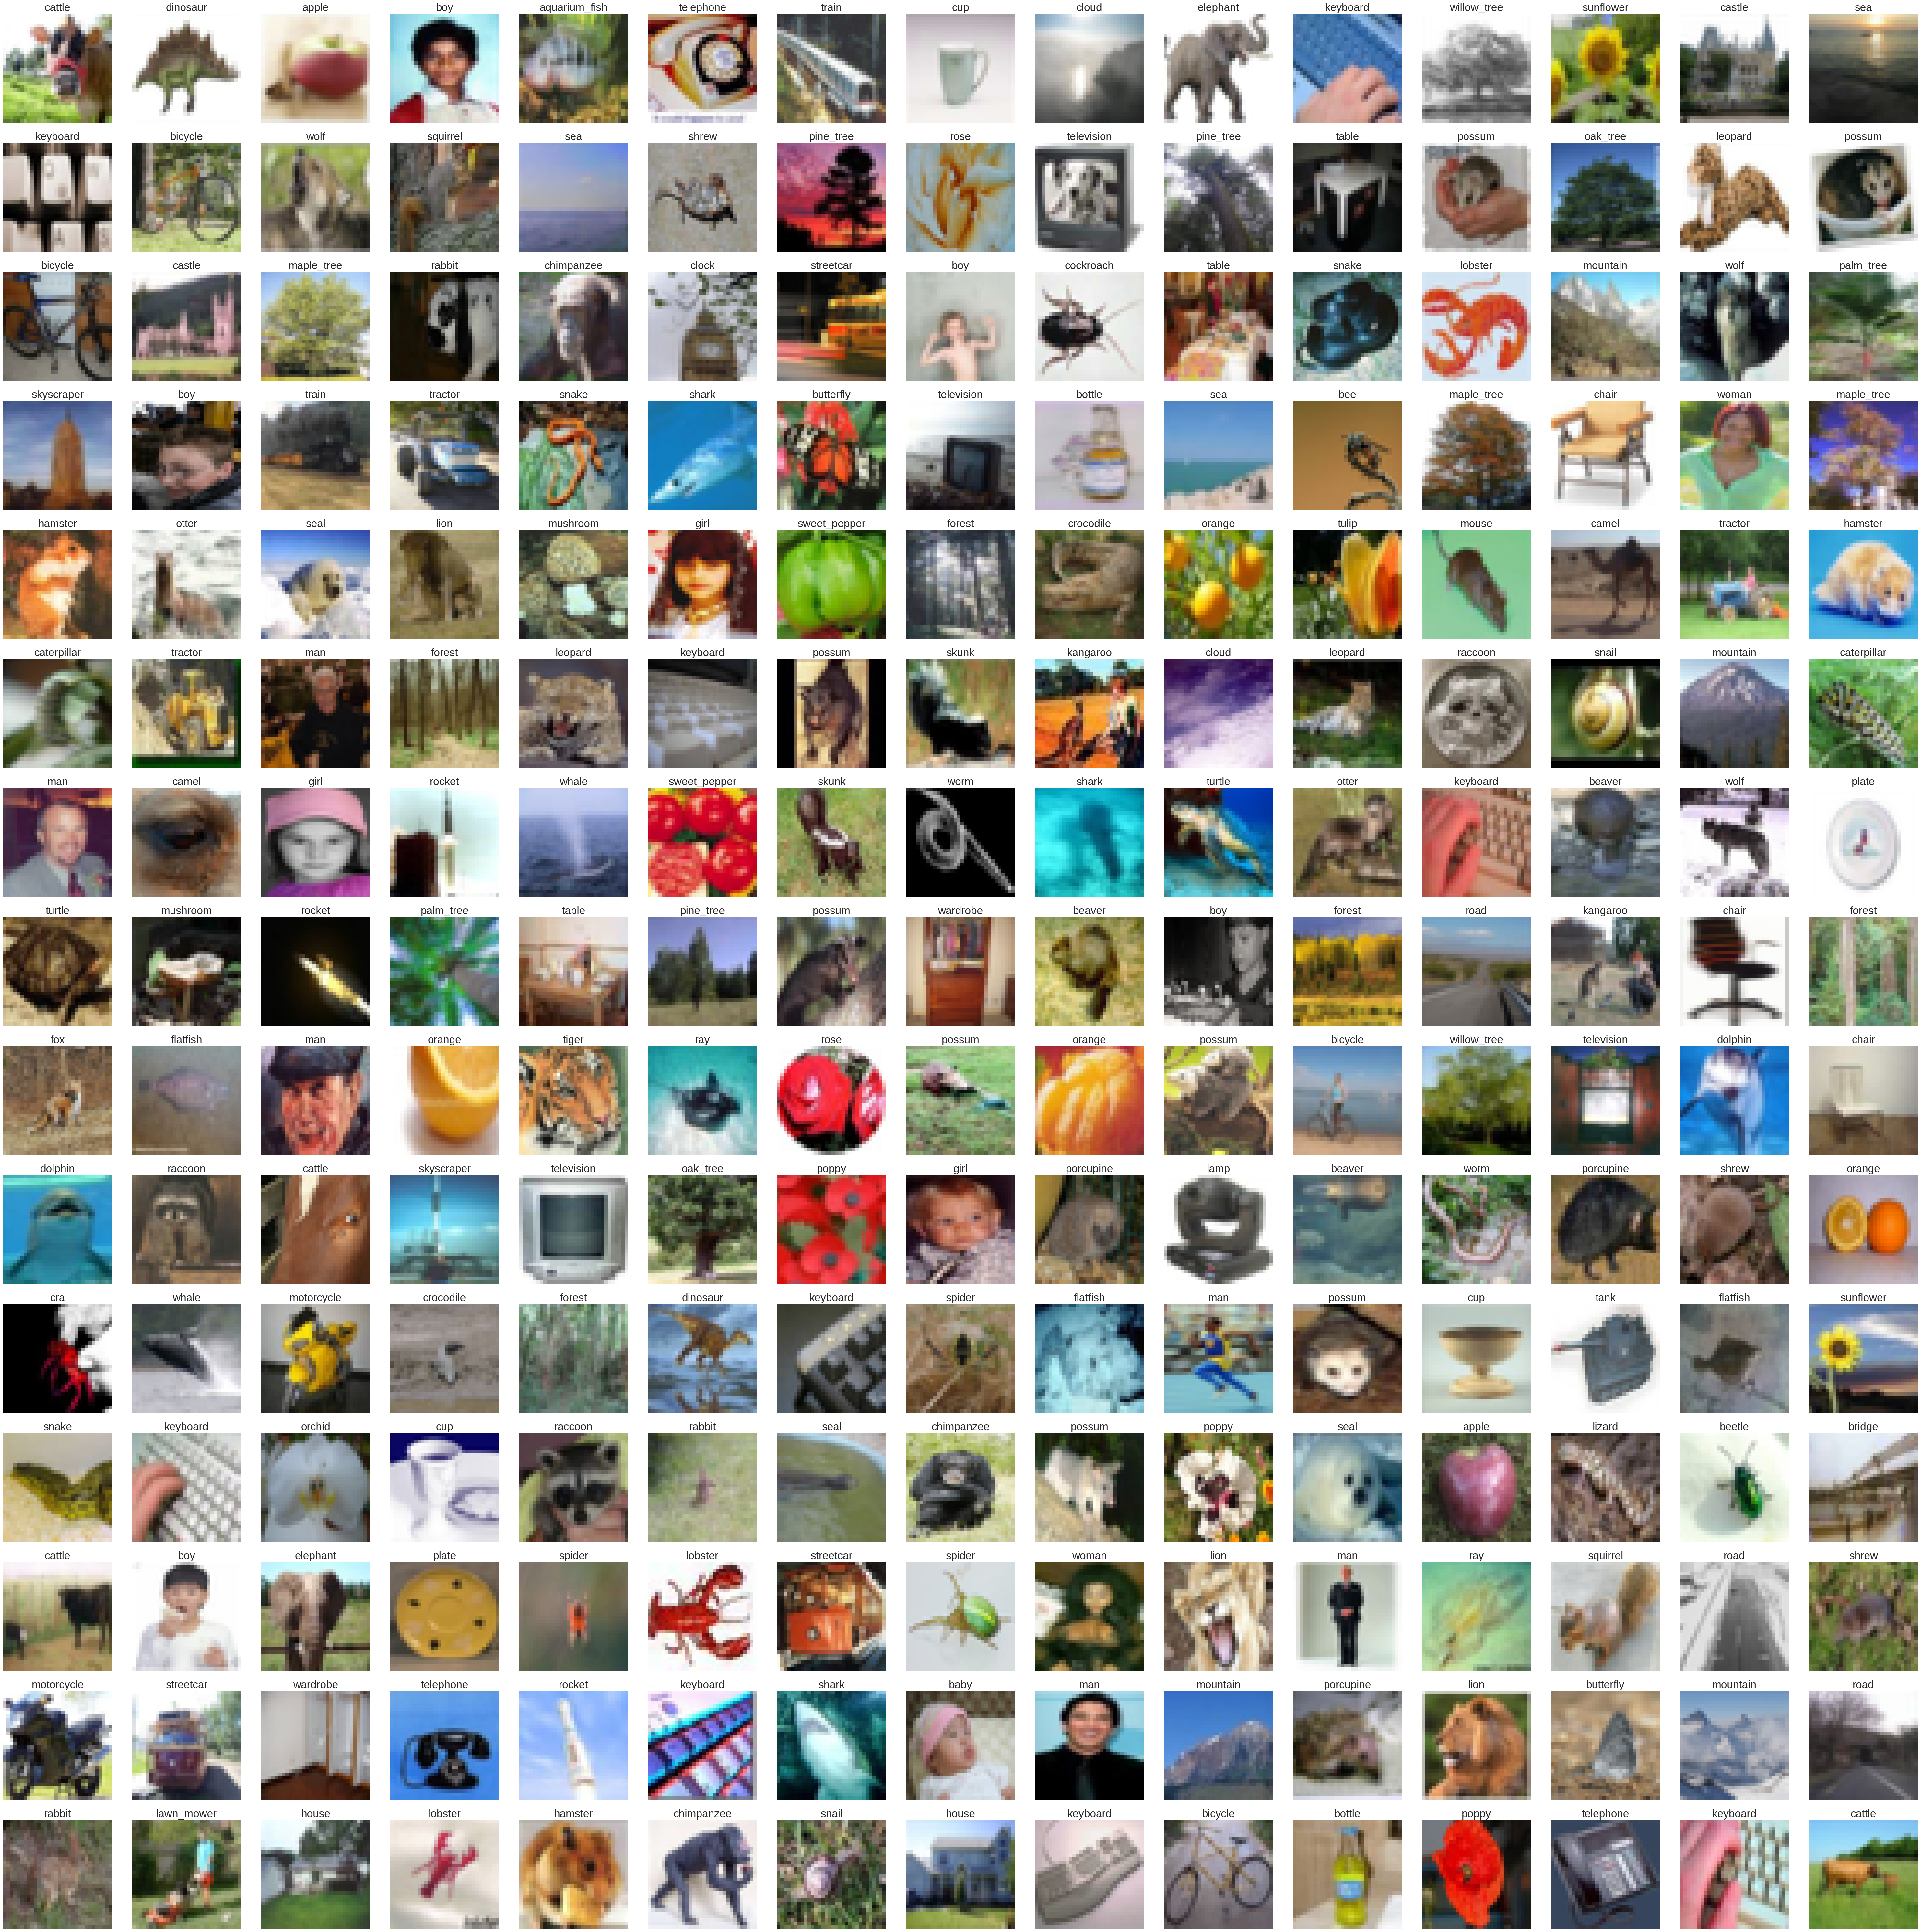

In [25]:
panel_sz = 4
grid_sz = (15, 15)

fig, axes = plt.subplots(nrows=grid_sz[0], ncols=grid_sz[1], figsize=(grid_sz[1]*panel_sz, grid_sz[0]*panel_sz))

for r in range(grid_sz[0]):
    for c in range(grid_sz[1]):
        ind = r * grid_sz[1] + c
        axes[r, c].imshow(x100_train[ind])
        axes[r, c].set_xticks([])
        axes[r, c].set_yticks([])
        axes[r, c].set_title(classnames100[y100_train[ind]])

plt.tight_layout()
plt.show()

### 5b. Train the Inception Net on CIFAR-100

See how well your Inception Net does at classifying CIFAR-100 images! Use same hyperparameters as CIFAR-10.

At the end of training, print out the CIFAR-100 test accuracy.

**Note:**
- Your dataset has 100 classes now, not 10. You will need to make a small update to your network config.
- Because CIFAR-100 has the same number of samples as CIFAR-10 and each color image sample has the same `(32, 32)` spatial resolution, training your InceptionNet on CIFAR-100 should take about the same time as it did on CIFAR-10 :)
- Make sure you are training on the **standardized** CIFAR-100.

In [26]:
x100_train, y100_train, x100_val, y100_val, x100_test, y100_test, classnames100 = get_dataset('cifar100')

In [27]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

model = InceptionNet(100, (32,32,3), reg = 1.5)
model.compile(optimizer='adamw')
model.fit(x100_train, y100_train, x100_val, y100_val, max_epochs = 10000, patience = 15, val_every = 1, verbose = True, lr_patience = 4)



---------------------------------------------------------------------------
Dense layer output(Output) shape: [1, 100]
Dropout layer output(Dropout) shape: [1, 580]
Global Avg Pooling 2D layer output(GlobalPool) shape: [1, 580]
MaxPool2D layer output(MaxPool3x3_2) shape: [1, 4, 4, 580]
Inception5:
	Conv2D1x1 layer output(Inception5/branch4_1_conv1x1) shape: [1, 8, 8, 128]
	MaxPool2D layer output(Inception5/branch4_0_maxpool3x3) shape: [1, 8, 8, 320]
	Conv2D layer output(Inception5/branch3_1_conv5x5) shape: [1, 8, 8, 128]
	Conv2D1x1 layer output(Inception5/branch3_0_conv1x1) shape: [1, 8, 8, 64]
	Conv2D layer output(Inception5/branch2_1_conv3x3) shape: [1, 8, 8, 196]
	Conv2D1x1 layer output(Inception5/branch2_0_conv1x1) shape: [1, 8, 8, 128]
	Conv2D1x1 layer output(Inception5/branch1_0_conv1x1) shape: [1, 8, 8, 128]
Inception4:
	Conv2D1x1 layer output(Inception4/branch4_1_conv1x1) shape: [1, 8, 8, 64]
	MaxPool2D layer output(Inception4/branch4_0_maxpool3x3) shape: [1, 8, 8, 320]
	Conv2D

Epoch 1: Training Loss = 4.1462, Validation Loss = 3.8326, Validation Accuracy = 0.1088
Epoch 1/10000 took 21.3794 seconds


Epoch 2: Training Loss = 3.6274, Validation Loss = 3.5584, Validation Accuracy = 0.1380
Epoch 2/10000 took 8.3251 seconds


Epoch 3: Training Loss = 3.4377, Validation Loss = 3.3843, Validation Accuracy = 0.1711
Epoch 3/10000 took 8.3678 seconds


Epoch 4: Training Loss = 3.2846, Validation Loss = 3.2226, Validation Accuracy = 0.1915
Epoch 4/10000 took 8.3629 seconds


Epoch 5: Training Loss = 3.1867, Validation Loss = 3.1371, Validation Accuracy = 0.2107
Epoch 5/10000 took 8.3502 seconds


Epoch 6: Training Loss = 3.1270, Validation Loss = 3.0808, Validation Accuracy = 0.2294
Epoch 6/10000 took 8.3425 seconds


Epoch 7: Training Loss = 3.0722, Validation Loss = 3.0273, Validation Accuracy = 0.2370
Epoch 7/10000 took 8.3226 seconds


Epoch 8: Training Loss = 3.0388, Validation Loss = 2.9842, Validation Accuracy = 0.2558
Epoch 8/10000 took 8.3450 seconds


Epoch 9: Training Loss = 3.0157, Validation Loss = 3.0191, Validation Accuracy = 0.2458
Epoch 9/10000 took 8.3265 seconds


Epoch 10: Training Loss = 2.9963, Validation Loss = 3.0409, Validation Accuracy = 0.2282
Epoch 10/10000 took 8.3175 seconds


Epoch 11: Training Loss = 2.9791, Validation Loss = 2.9469, Validation Accuracy = 0.2594
Epoch 11/10000 took 8.3304 seconds


Epoch 12: Training Loss = 2.9722, Validation Loss = 2.9175, Validation Accuracy = 0.2538
Epoch 12/10000 took 8.3536 seconds


Epoch 13: Training Loss = 2.9552, Validation Loss = 2.9138, Validation Accuracy = 0.2636
Epoch 13/10000 took 8.3513 seconds


Epoch 14: Training Loss = 2.9428, Validation Loss = 2.9247, Validation Accuracy = 0.2704
Epoch 14/10000 took 8.3685 seconds


Epoch 15: Training Loss = 2.9586, Validation Loss = 2.9418, Validation Accuracy = 0.2632
Epoch 15/10000 took 8.3471 seconds


Current lr= 0.001 Updated lr= 0.0005
Epoch 16: Training Loss = 2.9519, Validation Loss = 2.9196, Validation Accuracy = 0.2702
Epoch 16/10000 took 8.3546 seconds


Epoch 17: Training Loss = 2.7776, Validation Loss = 2.7611, Validation Accuracy = 0.2955
Epoch 17/10000 took 8.3557 seconds


Epoch 18: Training Loss = 2.7503, Validation Loss = 2.7059, Validation Accuracy = 0.3027
Epoch 18/10000 took 8.3654 seconds


Epoch 19: Training Loss = 2.7463, Validation Loss = 2.6782, Validation Accuracy = 0.3113
Epoch 19/10000 took 8.3637 seconds


Epoch 20: Training Loss = 2.7410, Validation Loss = 2.7852, Validation Accuracy = 0.2937
Epoch 20/10000 took 8.3669 seconds


Epoch 21: Training Loss = 2.7379, Validation Loss = 2.7232, Validation Accuracy = 0.3017
Epoch 21/10000 took 8.3595 seconds


Current lr= 0.0005 Updated lr= 0.00025
Epoch 22: Training Loss = 2.7593, Validation Loss = 2.7316, Validation Accuracy = 0.3025
Epoch 22/10000 took 8.3531 seconds


Epoch 23: Training Loss = 2.6315, Validation Loss = 2.7190, Validation Accuracy = 0.3075
Epoch 23/10000 took 8.3672 seconds


Epoch 24: Training Loss = 2.6195, Validation Loss = 2.6530, Validation Accuracy = 0.3217
Epoch 24/10000 took 8.3659 seconds


Epoch 25: Training Loss = 2.6219, Validation Loss = 2.5997, Validation Accuracy = 0.3333
Epoch 25/10000 took 8.3681 seconds


Epoch 26: Training Loss = 2.6142, Validation Loss = 2.6272, Validation Accuracy = 0.3289
Epoch 26/10000 took 8.3672 seconds


Epoch 27: Training Loss = 2.6086, Validation Loss = 2.5908, Validation Accuracy = 0.3337
Epoch 27/10000 took 8.3592 seconds


Epoch 28: Training Loss = 2.6057, Validation Loss = 2.5824, Validation Accuracy = 0.3383
Epoch 28/10000 took 8.3568 seconds


Epoch 29: Training Loss = 2.6249, Validation Loss = 2.6195, Validation Accuracy = 0.3231
Epoch 29/10000 took 8.3627 seconds


Epoch 30: Training Loss = 2.6365, Validation Loss = 2.5885, Validation Accuracy = 0.3379
Epoch 30/10000 took 8.3855 seconds


Current lr= 0.00025 Updated lr= 0.000125
Epoch 31: Training Loss = 2.6270, Validation Loss = 2.6496, Validation Accuracy = 0.3181
Epoch 31/10000 took 8.3616 seconds


Epoch 32: Training Loss = 2.5369, Validation Loss = 2.5515, Validation Accuracy = 0.3395
Epoch 32/10000 took 8.3696 seconds


Epoch 33: Training Loss = 2.5428, Validation Loss = 2.5394, Validation Accuracy = 0.3417
Epoch 33/10000 took 8.3654 seconds


Epoch 34: Training Loss = 2.5442, Validation Loss = 2.5484, Validation Accuracy = 0.3419
Epoch 34/10000 took 8.3645 seconds


Epoch 35: Training Loss = 2.5524, Validation Loss = 2.5563, Validation Accuracy = 0.3433
Epoch 35/10000 took 8.3841 seconds


Current lr= 0.000125 Updated lr= 6.25e-05
Epoch 36: Training Loss = 2.5394, Validation Loss = 2.6179, Validation Accuracy = 0.3329
Epoch 36/10000 took 8.3640 seconds


Epoch 37: Training Loss = 2.5022, Validation Loss = 2.4852, Validation Accuracy = 0.3560
Epoch 37/10000 took 8.3649 seconds


Epoch 38: Training Loss = 2.4842, Validation Loss = 2.5041, Validation Accuracy = 0.3574
Epoch 38/10000 took 8.3731 seconds


Epoch 39: Training Loss = 2.4954, Validation Loss = 2.5144, Validation Accuracy = 0.3498
Epoch 39/10000 took 8.3510 seconds


Epoch 40: Training Loss = 2.4881, Validation Loss = 2.5113, Validation Accuracy = 0.3538
Epoch 40/10000 took 8.3788 seconds


Epoch 41: Training Loss = 2.4848, Validation Loss = 2.4980, Validation Accuracy = 0.3586
Epoch 41/10000 took 8.3720 seconds


Epoch 42: Training Loss = 2.4885, Validation Loss = 2.5468, Validation Accuracy = 0.3482
Epoch 42/10000 took 8.3543 seconds


Epoch 43: Training Loss = 2.4874, Validation Loss = 2.4758, Validation Accuracy = 0.3538
Epoch 43/10000 took 8.3600 seconds


Epoch 44: Training Loss = 2.4824, Validation Loss = 2.4895, Validation Accuracy = 0.3590
Epoch 44/10000 took 8.3552 seconds


Epoch 45: Training Loss = 2.4859, Validation Loss = 2.4736, Validation Accuracy = 0.3640
Epoch 45/10000 took 8.3694 seconds


Epoch 46: Training Loss = 2.4928, Validation Loss = 2.4774, Validation Accuracy = 0.3628
Epoch 46/10000 took 8.4108 seconds


Epoch 47: Training Loss = 2.4844, Validation Loss = 2.5529, Validation Accuracy = 0.3458
Epoch 47/10000 took 8.3636 seconds


Current lr= 6.25e-05 Updated lr= 3.125e-05
Epoch 48: Training Loss = 2.4846, Validation Loss = 2.4887, Validation Accuracy = 0.3548
Epoch 48/10000 took 8.3589 seconds


Epoch 49: Training Loss = 2.4577, Validation Loss = 2.4730, Validation Accuracy = 0.3568
Epoch 49/10000 took 8.3620 seconds


Epoch 50: Training Loss = 2.4606, Validation Loss = 2.4538, Validation Accuracy = 0.3672
Epoch 50/10000 took 8.3515 seconds


Epoch 51: Training Loss = 2.4591, Validation Loss = 2.4716, Validation Accuracy = 0.3650
Epoch 51/10000 took 8.3739 seconds


Epoch 52: Training Loss = 2.4600, Validation Loss = 2.4627, Validation Accuracy = 0.3614
Epoch 52/10000 took 8.3701 seconds


Current lr= 3.125e-05 Updated lr= 1.5625e-05
Epoch 53: Training Loss = 2.4610, Validation Loss = 2.4561, Validation Accuracy = 0.3664
Epoch 53/10000 took 8.3541 seconds


Epoch 54: Training Loss = 2.4419, Validation Loss = 2.4534, Validation Accuracy = 0.3686
Epoch 54/10000 took 8.3596 seconds


Epoch 55: Training Loss = 2.4384, Validation Loss = 2.4457, Validation Accuracy = 0.3668
Epoch 55/10000 took 8.3650 seconds


Epoch 56: Training Loss = 2.4330, Validation Loss = 2.4480, Validation Accuracy = 0.3662
Epoch 56/10000 took 8.3625 seconds


Epoch 57: Training Loss = 2.4428, Validation Loss = 2.4463, Validation Accuracy = 0.3666
Epoch 57/10000 took 8.3854 seconds


Epoch 58: Training Loss = 2.4496, Validation Loss = 2.4447, Validation Accuracy = 0.3704
Epoch 58/10000 took 8.3801 seconds


Epoch 59: Training Loss = 2.4365, Validation Loss = 2.4474, Validation Accuracy = 0.3716
Epoch 59/10000 took 8.3610 seconds


Epoch 60: Training Loss = 2.4262, Validation Loss = 2.4467, Validation Accuracy = 0.3676
Epoch 60/10000 took 8.3474 seconds


Epoch 61: Training Loss = 2.4294, Validation Loss = 2.4434, Validation Accuracy = 0.3696
Epoch 61/10000 took 8.3583 seconds


Epoch 62: Training Loss = 2.4251, Validation Loss = 2.4472, Validation Accuracy = 0.3668
Epoch 62/10000 took 8.3636 seconds


Epoch 63: Training Loss = 2.4475, Validation Loss = 2.4514, Validation Accuracy = 0.3660
Epoch 63/10000 took 8.3577 seconds


Epoch 64: Training Loss = 2.4307, Validation Loss = 2.4395, Validation Accuracy = 0.3710
Epoch 64/10000 took 8.3732 seconds


Epoch 65: Training Loss = 2.4412, Validation Loss = 2.4391, Validation Accuracy = 0.3724
Epoch 65/10000 took 8.3526 seconds


Epoch 66: Training Loss = 2.4292, Validation Loss = 2.4388, Validation Accuracy = 0.3708
Epoch 66/10000 took 8.3484 seconds


Epoch 67: Training Loss = 2.4215, Validation Loss = 2.4339, Validation Accuracy = 0.3704
Epoch 67/10000 took 8.3721 seconds


Epoch 68: Training Loss = 2.4349, Validation Loss = 2.4319, Validation Accuracy = 0.3724
Epoch 68/10000 took 8.3653 seconds


Epoch 69: Training Loss = 2.4293, Validation Loss = 2.4442, Validation Accuracy = 0.3748
Epoch 69/10000 took 8.3673 seconds


Epoch 70: Training Loss = 2.4312, Validation Loss = 2.4324, Validation Accuracy = 0.3720
Epoch 70/10000 took 8.3605 seconds


Current lr= 1.5625e-05 Updated lr= 7.8125e-06
Epoch 71: Training Loss = 2.4308, Validation Loss = 2.4372, Validation Accuracy = 0.3726
Epoch 71/10000 took 8.3469 seconds


Epoch 72: Training Loss = 2.4242, Validation Loss = 2.4332, Validation Accuracy = 0.3664
Epoch 72/10000 took 8.3484 seconds


Epoch 73: Training Loss = 2.4168, Validation Loss = 2.4286, Validation Accuracy = 0.3724
Epoch 73/10000 took 8.3622 seconds


Epoch 74: Training Loss = 2.4219, Validation Loss = 2.4279, Validation Accuracy = 0.3724
Epoch 74/10000 took 8.3650 seconds


Epoch 75: Training Loss = 2.4188, Validation Loss = 2.4285, Validation Accuracy = 0.3780
Epoch 75/10000 took 8.3602 seconds


Epoch 76: Training Loss = 2.4156, Validation Loss = 2.4268, Validation Accuracy = 0.3776
Epoch 76/10000 took 8.3676 seconds


Epoch 77: Training Loss = 2.4212, Validation Loss = 2.4338, Validation Accuracy = 0.3766
Epoch 77/10000 took 8.3646 seconds


Epoch 78: Training Loss = 2.4277, Validation Loss = 2.4268, Validation Accuracy = 0.3730
Epoch 78/10000 took 8.3819 seconds


Current lr= 7.8125e-06 Updated lr= 3.90625e-06
Epoch 79: Training Loss = 2.4126, Validation Loss = 2.4300, Validation Accuracy = 0.3736
Epoch 79/10000 took 8.3560 seconds


Epoch 80: Training Loss = 2.4158, Validation Loss = 2.4262, Validation Accuracy = 0.3752
Epoch 80/10000 took 8.3643 seconds


Epoch 81: Training Loss = 2.4008, Validation Loss = 2.4240, Validation Accuracy = 0.3766
Epoch 81/10000 took 8.4015 seconds


Epoch 82: Training Loss = 2.4114, Validation Loss = 2.4226, Validation Accuracy = 0.3740
Epoch 82/10000 took 8.3575 seconds


Epoch 83: Training Loss = 2.4045, Validation Loss = 2.4219, Validation Accuracy = 0.3750
Epoch 83/10000 took 8.3734 seconds


Epoch 84: Training Loss = 2.4004, Validation Loss = 2.4250, Validation Accuracy = 0.3744
Epoch 84/10000 took 8.3673 seconds


Epoch 85: Training Loss = 2.3926, Validation Loss = 2.4210, Validation Accuracy = 0.3772
Epoch 85/10000 took 8.3688 seconds


Epoch 86: Training Loss = 2.4097, Validation Loss = 2.4240, Validation Accuracy = 0.3768
Epoch 86/10000 took 8.3548 seconds


Epoch 87: Training Loss = 2.4073, Validation Loss = 2.4261, Validation Accuracy = 0.3764
Epoch 87/10000 took 8.3669 seconds


Current lr= 3.90625e-06 Updated lr= 1.953125e-06
Epoch 88: Training Loss = 2.4118, Validation Loss = 2.4235, Validation Accuracy = 0.3776
Epoch 88/10000 took 8.3725 seconds


Epoch 89: Training Loss = 2.4068, Validation Loss = 2.4241, Validation Accuracy = 0.3760
Epoch 89/10000 took 8.3666 seconds


Epoch 90: Training Loss = 2.4130, Validation Loss = 2.4206, Validation Accuracy = 0.3748
Epoch 90/10000 took 8.3581 seconds


Epoch 91: Training Loss = 2.4147, Validation Loss = 2.4204, Validation Accuracy = 0.3784
Epoch 91/10000 took 8.3509 seconds


Epoch 92: Training Loss = 2.3924, Validation Loss = 2.4207, Validation Accuracy = 0.3752
Epoch 92/10000 took 8.3766 seconds


Epoch 93: Training Loss = 2.4124, Validation Loss = 2.4200, Validation Accuracy = 0.3750
Epoch 93/10000 took 8.3601 seconds


Epoch 94: Training Loss = 2.4053, Validation Loss = 2.4213, Validation Accuracy = 0.3756
Epoch 94/10000 took 8.3790 seconds


Epoch 95: Training Loss = 2.4128, Validation Loss = 2.4206, Validation Accuracy = 0.3770
Epoch 95/10000 took 8.3804 seconds


Epoch 96: Training Loss = 2.4000, Validation Loss = 2.4180, Validation Accuracy = 0.3750
Epoch 96/10000 took 8.3673 seconds


Epoch 97: Training Loss = 2.4030, Validation Loss = 2.4218, Validation Accuracy = 0.3724
Epoch 97/10000 took 8.3507 seconds


Epoch 98: Training Loss = 2.4224, Validation Loss = 2.4201, Validation Accuracy = 0.3776
Epoch 98/10000 took 8.3887 seconds


Current lr= 1.953125e-06 Updated lr= 9.765625e-07
Epoch 99: Training Loss = 2.4127, Validation Loss = 2.4231, Validation Accuracy = 0.3760
Epoch 99/10000 took 8.3513 seconds


Epoch 100: Training Loss = 2.3893, Validation Loss = 2.4185, Validation Accuracy = 0.3732
Epoch 100/10000 took 8.3775 seconds


Epoch 101: Training Loss = 2.4100, Validation Loss = 2.4183, Validation Accuracy = 0.3770
Epoch 101/10000 took 8.3638 seconds


Epoch 102: Training Loss = 2.4089, Validation Loss = 2.4184, Validation Accuracy = 0.3776
Epoch 102/10000 took 8.3544 seconds


Epoch 103: Training Loss = 2.4003, Validation Loss = 2.4171, Validation Accuracy = 0.3748
Epoch 103/10000 took 8.3774 seconds


Epoch 104: Training Loss = 2.4102, Validation Loss = 2.4183, Validation Accuracy = 0.3768
Epoch 104/10000 took 8.3855 seconds


Epoch 105: Training Loss = 2.4064, Validation Loss = 2.4189, Validation Accuracy = 0.3770
Epoch 105/10000 took 8.3871 seconds


Current lr= 9.765625e-07 Updated lr= 4.882813e-07
Epoch 106: Training Loss = 2.3958, Validation Loss = 2.4195, Validation Accuracy = 0.3768
Epoch 106/10000 took 8.3578 seconds


Epoch 107: Training Loss = 2.3976, Validation Loss = 2.4176, Validation Accuracy = 0.3766
Epoch 107/10000 took 8.3620 seconds


Epoch 108: Training Loss = 2.4075, Validation Loss = 2.4176, Validation Accuracy = 0.3780
Epoch 108/10000 took 8.3598 seconds


Epoch 109: Training Loss = 2.3934, Validation Loss = 2.4176, Validation Accuracy = 0.3744
Epoch 109/10000 took 8.3733 seconds


Epoch 110: Training Loss = 2.4081, Validation Loss = 2.4178, Validation Accuracy = 0.3762
Epoch 110/10000 took 8.3830 seconds


Epoch 111: Training Loss = 2.3926, Validation Loss = 2.4172, Validation Accuracy = 0.3742
Epoch 111/10000 took 8.3582 seconds


Epoch 112: Training Loss = 2.4075, Validation Loss = 2.4168, Validation Accuracy = 0.3760
Epoch 112/10000 took 8.3635 seconds


Epoch 113: Training Loss = 2.4064, Validation Loss = 2.4171, Validation Accuracy = 0.3760
Epoch 113/10000 took 8.3608 seconds


Epoch 114: Training Loss = 2.4136, Validation Loss = 2.4178, Validation Accuracy = 0.3762
Epoch 114/10000 took 8.3718 seconds


Current lr= 4.882813e-07 Updated lr= 2.4414064e-07
Epoch 115: Training Loss = 2.4062, Validation Loss = 2.4177, Validation Accuracy = 0.3772
Epoch 115/10000 took 8.3811 seconds


Epoch 116: Training Loss = 2.3955, Validation Loss = 2.4171, Validation Accuracy = 0.3770
Epoch 116/10000 took 8.3728 seconds


Epoch 117: Training Loss = 2.3922, Validation Loss = 2.4170, Validation Accuracy = 0.3762
Epoch 117/10000 took 8.3461 seconds


Epoch 118: Training Loss = 2.3973, Validation Loss = 2.4167, Validation Accuracy = 0.3760
Epoch 118/10000 took 8.3453 seconds


Epoch 119: Training Loss = 2.3894, Validation Loss = 2.4171, Validation Accuracy = 0.3770
Epoch 119/10000 took 8.3493 seconds


Epoch 120: Training Loss = 2.4025, Validation Loss = 2.4166, Validation Accuracy = 0.3764
Epoch 120/10000 took 8.3593 seconds


Epoch 121: Training Loss = 2.4014, Validation Loss = 2.4169, Validation Accuracy = 0.3770
Epoch 121/10000 took 8.4350 seconds


Epoch 122: Training Loss = 2.3973, Validation Loss = 2.4168, Validation Accuracy = 0.3754
Epoch 122/10000 took 8.4248 seconds


Epoch 123: Training Loss = 2.3830, Validation Loss = 2.4163, Validation Accuracy = 0.3758
Epoch 123/10000 took 8.4171 seconds


Epoch 124: Training Loss = 2.4028, Validation Loss = 2.4169, Validation Accuracy = 0.3752
Epoch 124/10000 took 8.3949 seconds


Epoch 125: Training Loss = 2.3957, Validation Loss = 2.4166, Validation Accuracy = 0.3764
Epoch 125/10000 took 8.3700 seconds


Epoch 126: Training Loss = 2.4057, Validation Loss = 2.4164, Validation Accuracy = 0.3776
Epoch 126/10000 took 8.3648 seconds


Epoch 127: Training Loss = 2.3927, Validation Loss = 2.4163, Validation Accuracy = 0.3744
Epoch 127/10000 took 8.3866 seconds


Epoch 128: Training Loss = 2.3952, Validation Loss = 2.4170, Validation Accuracy = 0.3750
Epoch 128/10000 took 8.3562 seconds


Epoch 129: Training Loss = 2.4003, Validation Loss = 2.4171, Validation Accuracy = 0.3754
Epoch 129/10000 took 8.3643 seconds


Epoch 130: Training Loss = 2.3972, Validation Loss = 2.4172, Validation Accuracy = 0.3760
Epoch 130/10000 took 8.3634 seconds


Epoch 131: Training Loss = 2.4142, Validation Loss = 2.4173, Validation Accuracy = 0.3762
Epoch 131/10000 took 8.3546 seconds


Epoch 132: Training Loss = 2.4001, Validation Loss = 2.4167, Validation Accuracy = 0.3752
Epoch 132/10000 took 8.5991 seconds


Epoch 133: Training Loss = 2.4084, Validation Loss = 2.4171, Validation Accuracy = 0.3762
Epoch 133/10000 took 8.5527 seconds


Epoch 134: Training Loss = 2.3976, Validation Loss = 2.4168, Validation Accuracy = 0.3766
Epoch 134/10000 took 8.5306 seconds


Epoch 135: Training Loss = 2.4002, Validation Loss = 2.4166, Validation Accuracy = 0.3774
Epoch 135/10000 took 8.4476 seconds


Epoch 136: Training Loss = 2.3956, Validation Loss = 2.4174, Validation Accuracy = 0.3764
Epoch 136/10000 took 8.8304 seconds
